In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.min_rows', 10000)
pd.set_option('display.max_rows', 20000)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
plt.rcParams["figure.figsize"] = (20,10)

# INDEX

* [Loading data](#load_data)
    * [Columns meaning](#cols_mean)
<br><br>    
* [PREPROCESSING AND ADDING ADDITIONAL FEATURES](#preprocess)
    * [Original number of events](#num_events)
    * [Mark sessions with start or end actions before or after server_time](#bef_af_s)
    * [Estimate visit_total_time_sum (session_duration)](#visit_total_time_sum)
    * [Common events duration estimation](#event_dur)
    * [Final events duration estimation](#final_event_dur)
    * [Maximum event duration](#max_event_dur)
    * [Mark events with durations too long](#event_long)
    * [Event duration outliers explanation](#outliers_explan)
    * [Mark sessions with cyclical events with same duration](#cycle)
    * [Mark sessions with consecutive long events](#long_consecutive)
    * [Combine contigous events of the same application](#combine_events)
    * [Add number of applications used on each session](#num_app)
    * [Add number of unique applications used on each session](#unique_num_app)
    * [Add list of apps used in session](#list_app)
    * [Mark users with some loggin as logged always](#logged_treated)
    * [Add string categories for users](#users_cat)
    * [Calculate session duration](#sess_dur)
    * [Calculate mean event duration](#mean_event_dur)
    * [Mark sessions with one event and zero duration](#one_event)
    * [Mark app-11 scrapers as outlier](#scrappers)
    * [Add string categories for session duration](#sess_dur_cat)  
<br><br>  
* [AUXILIAR PLOT FUNCTIONS](#aux_plot)
<br><br>  
* [FILTERED DATASETS CREATION](#dataset_creation)
<br><br> 
* [PLOTS](#plots)
    * [Plots dataset original](#plots_original) 
    * [Event durations before and after apply rules](#event_dur_comparison)    
    * [Apps durations before and after apply rules](#apps_dur_comparison)  
    * [Applications mean/median durations after apply rules](#app_mean_duration)  
    * [Plots after apply rules](#plots_after_rules) 
    * [Plots after apply rules and remove sessions of one app](#plots_after_rules_2) 

In [ ]:
import glob
path = r'C:\DRO\DCL_rawdata_files' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)

<a class="anchor" id="load_data"></a>
# Loading data 

In [5]:
df = pd.read_csv("vaishali_cleaned_data_sep20.csv")
# object to datetime conversion
df["server_time"] = pd.to_datetime(df["server_time"],format="%Y-%m-%d %H:%M:%S.%f")
df["visit_first_action_time"] = pd.to_datetime(df["visit_first_action_time"],format="%Y-%m-%d %H:%M:%S.%f") 
df["visit_last_action_time"] = pd.to_datetime(df["visit_last_action_time"],format="%Y-%m-%d %H:%M:%S.%f") 
# remove old index
df.drop(columns=['Unnamed: 0'], inplace=True)
# string columns conversion
df.rename(columns= {'appname_c': 'appname_int'}, inplace=True)
df['appname_c'] = 'app-' + df['appname_int'].astype('str')
df['event_action_c'] = 'action-' + df['event_action_c'].astype('str')

In [6]:
df.info(verbose=True, null_counts=True)

<ipython-input-6-6ac79f7ef903>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594420 entries, 0 to 3594419
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   server_time              3594420 non-null  datetime64[ns]
 1   visitor_id_c             3594420 non-null  int64         
 2   event_action_c           3594420 non-null  object        
 3   appname_int              3594420 non-null  int64         
 4   session_hk_c             3594420 non-null  int64         
 5   time_spent_ref_action    3594420 non-null  int64         
 6   visit_total_time         3594420 non-null  int64         
 7   session_duration         3594420 non-null  int64         
 8   visit_first_action_time  3594420 non-null  datetime64[ns]
 9   visit_last_action_time   3594420 non-null  datetime64[ns]
 10  step_session             3594420 non-null  int64         
 11  user_logged              3594420 non-null  int64         
 12  

In [7]:
print(f"Number of events : {df.shape[0]}")
print(f"Number of sessions : {len(df['session_hk_c'].unique())}")
print(f"Number of users : {len(df['visitor_id_c'].unique())}")

Number of events : 3594420
Number of sessions : 488032
Number of users : 355902


In [8]:
df[df["session_hk_c"]==0][["session_hk_c","visitor_id_c","appname_int","server_time","time_spent_ref_action"]].head(5)

session_hk_c  visitor_id_c  appname_int         server_time  \
0             0         77997           11 2020-09-21 12:25:57   
1             0         77997           11 2020-09-21 12:26:07   
2             0         77997           11 2020-09-21 12:26:09   
3             0         77997           11 2020-09-21 12:27:23   
4             0         77997           11 2020-09-21 12:27:25   

   time_spent_ref_action  
0                      2  
1                     10  
2                      2  
3                     74  
4                      2

<a class="anchor" id="cols_mean"></a>
<h3>COLUMNS MEANING</h3>
<ul>
    <li><b>server_time: </b>Server time (more reliable than session_duration)</li>
    <li><b>visitor_id_c: </b>User identifier (if cookies are cleaned, it has another id)</li>
    <li><b>event_action_c: </b>Actions (click, enter to some place...)</li>
    <li><b>appname_c: </b> Aplication used</li>
    <li><b>session_hk_c: </b>Session identifier</li>
    <li><b>time_spent_ref_action: </b>Event duration (provided by matomo)</li>
    <li><b>visit_total_time: 
        </b>Visit total time (seconds) provided by matomo (probably wrong) (sum of app session_duration)
    </li>
    <li><b>session_duration: 
        </b>Usage total time (seconds) of an unique app during a session provided by matomo (probably wrong).It calculated by substracting visit_last_action_time and visit_first_action_time
    </li>
    <li><b>visit_first_action_time: 
        </b>Server time of the first action of an unique app during a session.
    </li>
    <li><b>visit_last_action_time: 
        </b>Server time of the last action of an unique app during a session.<br>
    </li>
    <li><b>step_session: </b>Record position inside its session</li>
    <li><b>user_logged: </b>0-> not logged user 1-> logged user (common user)</li>
    <li><b>user_returning: </b> 0-> User that never visited the page before. 1 -> User that visited the page before</li>      
</ul>

<h3>GOOD EXAMPLES</h3>
<ul>
    <li><b>session_hk_c = 0: </b> (81 events)</li>
    <li><b>session_hk_c = 488029: </b> (4 events)</li>
    <li><b>session_hk_c = 2:  </b>(2 events)</li>
    <li><b>session_hk_c = 193834: </b> (Possible JS error)</li>
    <li><b>session_hk_c = 147161: </b> (Possible JS error) (cycle 10 min, 20 min...)</li>
    <li><b>session_hk_c = 160801/26583: </b> (Possible JS error) (10 min events, app-61)</li>
    <li><b>session_hk_c = 369135/177795: </b> (Possible JS error) (2 s events, app-11, very long sessions)</li>
    <li><b>session_hk_c = 100: </b> (Possible session closing error)</li>
</ul>

In [8]:
df.head(81)

server_time  visitor_id_c event_action_c  appname_int  \
0  2020-09-21 12:25:57         77997       action-1           11   
1  2020-09-21 12:26:07         77997       action-1           11   
2  2020-09-21 12:26:09         77997       action-1           11   
3  2020-09-21 12:27:23         77997       action-1           11   
4  2020-09-21 12:27:25         77997       action-1           11   
5  2020-09-21 12:31:02         77997       action-1           11   
6  2020-09-21 12:31:03         77997       action-1           11   
7  2020-09-21 12:31:11         77997       action-1           11   
8  2020-09-21 12:31:13         77997       action-1           11   
9  2020-09-21 12:31:21         77997       action-1           11   
10 2020-09-21 12:31:23         77997       action-1           11   
11 2020-09-21 12:31:46         77997       action-1           11   
12 2020-09-21 12:31:51         77997       action-1           11   
13 2020-09-21 12:32:51         77997       action-1           11   
14 2020-09-21 12:32:53         77997       action-1           11   
15 2020-09-21 12:32:59         77997       action-1           11   
16 2020-09-21 12:33:01         77997       action-1           11   
17 2020-09-21 12:33:31         77997       action-1           11   
18 2020-09-21 12:33:33         77997       action-1           11   
19 2020-09-21 12:33:53         77997       action-1           11   
20 2020-09-21 12:33:55         77997       action-1           11   
21 2020-09-21 12:34:10         77997       action-1           11   
22 2020-09-21 12:34:12         77997       action-1           11   
23 2020-09-21 12:34:45         77997       action-1           11   
24 2020-09-21 12:34:47         77997       action-1           11   
25 2020-09-21 12:34:56         77997       action-1           11   
26 2020-09-21 12:34:58         77997       action-1           11   
27 2020-09-21 12:35:44         77997       action-1           11   
28 2020-09-21 12:35:46         77997       action-1           11   
29 2020-09-21 12:36:16         77997       action-1           11   
30 2020-09-21 12:36:18         77997       action-1           11   
31 2020-09-21 12:36:53         77997       action-1           11   
32 2020-09-21 12:36:57         77997       action-1           11   
33 2020-09-21 12:37:12         77997       action-1           11   
34 2020-09-21 12:37:14         77997       action-1           11   
35 2020-09-21 12:37:23         77997       action-1           11   
36 2020-09-21 12:37:27         77997       action-1           11   
37 2020-09-21 12:39:10         77997       action-1           11   
38 2020-09-21 12:39:11         77997       action-1           11   
39 2020-09-21 12:40:35         77997       action-1           11   
40 2020-09-21 12:40:38         77997       action-1           11   
41 2020-09-21 12:40:50         77997       action-1           11   
42 2020-09-21 12:40:54         77997       action-1           11   
43 2020-09-21 12:41:15         77997       action-1           11   
44 2020-09-21 12:41:19         77997       action-1           11   
45 2020-09-21 12:41:48         77997       action-1           11   
46 2020-09-21 12:41:57         77997       action-1           11   
47 2020-09-21 12:42:04         77997       action-1           11   
48 2020-09-21 12:42:05         77997       action-1           11   
49 2020-09-21 12:42:51         77997       action-1           11   
50 2020-09-21 12:42:53         77997       action-1           11   
51 2020-09-21 12:43:44         77997       action-1           11   
52 2020-09-21 12:43:46         77997       action-1           11   
53 2020-09-21 12:43:58         77997       action-1           11   
54 2020-09-21 12:44:00         77997       action-1           11   
55 2020-09-21 12:45:56         77997       action-1           11   
56 2020-09-21 12:45:58         77997       action-1           11   
57 2020-09-21 12:47:47         77997       action-1           11   

In [9]:
df["server_time"].max()

Timestamp('2020-09-30 23:59:54')

<a class="anchor" id="preprocess"></a>
<h1 id="add">PREPROCESSING AND ADDING ADDITIONAL FEATURES</h1>

<p>In this section, multiple features were added:</p>
<ul>
    <li><b>num_events: </b> Number of events of the session (before combine contigous apps)</li>
    <li><b>event_duration: </b>Duration of a event (s) (before combine contigous apps, after this disppears)</li>
    <li><b>calculated_app_duration: </b>Time that user remains in the same app in seconds. This time can be 0 in the last app of a session if only has an event.</li>
    <li><b>app_num_events: </b>Number of events that were combined in an app.</li>
    <li><b>num_apps: </b> Number of applications visited during a session.</li>
    <li><b>num_apps_without_wipo_account:</b>Number of applications visited during a session without count wipo account</li>
    <li><b>num_unique_apps: </b> Number of applications visited during a session.</li>
    <li><b>used_app_list: </b>List of applications visited during a session.</li>
    <li><b>user_logged_treated: </b> user_logged modified (being set as 1 for all users who ever logged in)</li>
    <li><b>user_log_info: </b>Description string with logging data: ["logged", "not logged"] </li>
    <li><b>user_returning_info: </b>Description string with returning data:["returning", "not returning"]</li>
    <li><b>user_description: </b>Description string with logging data and returning data</li>
    <li><b>calculated_session_duration: </b>Session duration calculated based on event's server time.</li>
    <li><b>session_duration_range: </b>String with session duration inside the defined ranges.</li>
    <li><b>mean_event_duration:</b>Session mean event duration</li>
    <li><b>app_mean_event_duration:</b>App mean event duration</li>
    <li><b>visit_total_time_sum: </b>Session duration (with provided feature)</li>
    
</ul>
<br>
<p>Outlier features:</p>
<ul>
        <li><b>event_duration_outlier: </b>Marks if a session contains events with durations bigger than 25 mins.</li>
        <li><b>cyclic_event_outlier: </b>Marks if a session has some strange behaviour with common patterns of not clossing session errors.
            <br>The pattern is identified as a two periodic events emission with similar durations.
            <br>It is necessary to see a sequence of e1 e2 e1 e2 e1 e2 no mark the session as outlier.
            <br>It is also necessary that the events have durations of at least 15 seconds.</li>
    <li><b>long_consecutives_outlier:</b>Mark sessions as outliers if there are 6 consecutive events with duration of at least 10 mins</li>
    <li><b>one_event_outlier:</b>Mark sessions with only one event and with duration less than a second</li>
    <li><b>scrapper_outlier:</b>Mark sessions that only uses app-11 (Global brand) and all its events have a duration of less than 10 seconds</li>
    <li><b>visit_actions_outlier:</b>Mark sessions where the first or last event differ in at least 60 seconds with the first action or the last action</li>
</ul>

<a class="anchor" id="num_events"></a>
## Original number of events

In [9]:
df["num_events"] = df.groupby("session_hk_c")["session_hk_c"].transform('count')

<a class="anchor" id="bef_af_s"></a>
##  Mark sessions with start or end actions before or after server_time

In [11]:
bad_end_sessions = df[(df["step_session"]==df["num_events"]-1)&\
                ((df["visit_last_action_time"]-df["server_time"]).dt.total_seconds()>60)]\
                    ["session_hk_c"]

bad_start_sessions = df[(df["step_session"]==0)&((df["server_time"]-df["visit_first_action_time"]).dt.total_seconds()>60)]\
                    ["session_hk_c"]

In [12]:
df["visit_actions_outlier"] = 0
df["visit_actions_outlier"][(df["session_hk_c"].isin(bad_end_sessions))|(df["session_hk_c"].isin(bad_start_sessions))] = 1

In [13]:
print("Sessions marked as outliers because action time not correct: {}/{}".format(
        df[(df["visit_actions_outlier"]==1)&(df["step_session"]==0)].shape[0], len(df['session_hk_c'].unique())
))

Sessions marked as outliers because action time not correct: 8476/488032


<a class="anchor" id="visit_total_time_sum"></a>
## Estimate visit_total_time_sum (session_duration)

In [14]:
visit_total_time_df = df[["session_hk_c","appname_c","visit_total_time"]].drop_duplicates()\
                            .groupby("session_hk_c")[["visit_total_time"]].agg("sum")
visit_total_time_df.rename(columns= {'visit_total_time': 'visit_total_time_sum'}, inplace=True)

In [15]:
df = df.merge(visit_total_time_df, how="left", left_on="session_hk_c", right_index=True)

<a class="anchor" id="event_dur"></a>
## Common events duration estimation

In [16]:
df['elapsedtimedf1'] = df.groupby("session_hk_c")["server_time"].diff().dt.total_seconds().fillna(0)
df['event_duration'] = df.groupby('session_hk_c')['elapsedtimedf1'].shift(-1).fillna(0)
df.drop(columns=["elapsedtimedf1"],inplace=True)

In [17]:
df[df["session_hk_c"]==177795][["session_hk_c","visitor_id_c","appname_int","server_time","event_duration"]].shape

(18256, 5)

<a class="anchor" id="final_event_dur"></a>
## Final events duration estimation

In [18]:
df = df.sort_values(["session_hk_c","server_time"])

In [19]:
df_shifted= df[["session_hk_c","server_time"]].shift(-1)
condition_results = df["session_hk_c"] != df_shifted["session_hk_c"]

In [20]:
df["event_duration"][condition_results]  = (df[condition_results]["visit_last_action_time"] - df[condition_results]["server_time"]).dt.total_seconds()

In [21]:
del df_shifted

<a class="anchor" id="max_event_dur"></a>
## Maximum event duration

In [22]:
df["max_event_duration"] = df.groupby("session_hk_c")["event_duration"].transform("max")

<a class="anchor" id="event_long"></a>
## Mark events with durations too long

In [23]:
# sessions with some event with a duration > 30 mins
sess_dur_outlier = df.loc[df["event_duration"]>(60*25),'session_hk_c'] 
df["event_duration_outlier"] = 0
df["event_duration_outlier"][df["session_hk_c"].isin(sess_dur_outlier)] = 1

In [24]:
num_sessions_dropped = df[["session_hk_c","event_duration_outlier"]][df["event_duration_outlier"]==1].drop_duplicates().shape[0]
print(f"Sessions marked as outliers because event duration: {num_sessions_dropped}/{len(df['session_hk_c'].unique())}")

Sessions marked as outliers because event duration: 17740/488032


<a class="anchor" id="outliers_explan"></a>
## Event duration outliers explanation

There are events with very long durations. <br>
This is caused because the session contains events with server times very different.<br>
As we can see in the example, in this cases, the variables visit_last_action_time let us know that the user is inactive.

In [25]:
df_events = df.copy()
df_events["next_event_server_time"]= df_events.groupby("session_hk_c")["server_time"].shift(-1)

In [26]:
df_events[["session_hk_c","server_time","visit_first_action_time","visit_last_action_time","next_event_server_time","event_duration"]]\
            [df_events["event_duration"]>10000].head(5)

session_hk_c         server_time visit_first_action_time  \
834            100 2020-09-02 07:42:53     2020-09-02 07:42:53   
835            100 2020-09-03 07:46:14     2020-09-03 07:46:14   
2734           405 2020-09-10 07:39:02     2020-09-10 07:38:30   
2736           405 2020-09-17 11:59:57     2020-09-17 11:58:50   
2737           405 2020-09-22 09:24:20     2020-09-22 09:24:20   

     visit_last_action_time next_event_server_time  event_duration  
834     2020-09-02 07:42:54    2020-09-03 07:46:14         86601.0  
835     2020-09-03 07:46:14    2020-09-04 07:13:17         84423.0  
2734    2020-09-10 07:39:02    2020-09-17 11:58:50        620388.0  
2736    2020-09-17 11:59:57    2020-09-22 09:24:20        422663.0  
2737    2020-09-22 09:24:21    2020-09-25 09:11:21        258421.0

<a class="anchor" id="cycle"></a>
## Mark sessions with cyclical events with same duration

In [27]:
aux = pd.DataFrame()
aux["session_hk_c"] = df["session_hk_c"]
aux["event_duration"] = df["event_duration"]


aux["event_duration_1"] = aux.groupby("session_hk_c")["event_duration"].shift(-1)
aux["event_duration_2"] = aux.groupby("session_hk_c")["event_duration"].shift(-2)
aux["event_duration_3"] = aux.groupby("session_hk_c")["event_duration"].shift(-3)
aux["event_duration_4"] = aux.groupby("session_hk_c")["event_duration"].shift(-4)
aux["event_duration_5"] = aux.groupby("session_hk_c")["event_duration"].shift(-5)

In [28]:
seconds_diff = 10
condition_results = (
                        (np.absolute(aux["event_duration"]-aux["event_duration_2"])<seconds_diff)&\
                        (np.absolute(aux["event_duration"]-aux["event_duration_4"])<seconds_diff)&\
                        (np.absolute(aux["event_duration_1"]-aux["event_duration_3"])<seconds_diff)&\
                        (np.absolute(aux["event_duration_1"]-aux["event_duration_5"])<seconds_diff)&\
                        (~aux["event_duration"].isna())&(~aux["event_duration_1"].isna())\
                        &(aux["event_duration"]>15) & (aux["event_duration_1"]>15)
                    )
aux["is_cycle"] = condition_results
outlier_sessions = aux[condition_results]["session_hk_c"].unique()

In [29]:
df["cyclic_event_outlier"] = 0
df["cyclic_event_outlier"][df["session_hk_c"].isin(outlier_sessions)] = 1

In [30]:
df_events["cyclic_event_outlier"] = df["cyclic_event_outlier"]
del aux

In [31]:
print(f"Sessions marked as outliers because cyclic event: {len(outlier_sessions)}/{len(df['session_hk_c'].unique())}")

Sessions marked as outliers because cyclic event: 2607/488032


<a class="anchor" id="long_consecutive"></a>
## Mark sessions with consecutive long events

In [32]:
aux = pd.DataFrame()
aux["session_hk_c"] = df["session_hk_c"]
aux["event_duration_min"] = df["event_duration"]/60

aux["event_duration_min_1"] = aux.groupby("session_hk_c")["event_duration_min"].shift(-1)
aux["event_duration_min_2"] = aux.groupby("session_hk_c")["event_duration_min"].shift(-2)
aux["event_duration_min_3"] = aux.groupby("session_hk_c")["event_duration_min"].shift(-3)
aux["event_duration_min_4"] = aux.groupby("session_hk_c")["event_duration_min"].shift(-4)
aux["event_duration_min_5"] = aux.groupby("session_hk_c")["event_duration_min"].shift(-5)

In [33]:
aux

session_hk_c  event_duration_min  event_duration_min_1  \
0                   0            0.166667              0.033333   
1                   0            0.033333              1.233333   
2                   0            1.233333              0.033333   
3                   0            0.033333              3.616667   
4                   0            3.616667              0.016667   
5                   0            0.016667              0.133333   
6                   0            0.133333              0.033333   
7                   0            0.033333              0.133333   
8                   0            0.133333              0.033333   
9                   0            0.033333              0.383333   
10                  0            0.383333              0.083333   
11                  0            0.083333              1.000000   
12                  0            1.000000              0.033333   
13                  0            0.033333              0.100000   
14                  0            0.100000              0.033333   
15                  0            0.033333              0.500000   
16                  0            0.500000              0.033333   
17                  0            0.033333              0.333333   
18                  0            0.333333              0.033333   
19                  0            0.033333              0.250000   
20                  0            0.250000              0.033333   
21                  0            0.033333              0.550000   
22                  0            0.550000              0.033333   
23                  0            0.033333              0.150000   
24                  0            0.150000              0.033333   
25                  0            0.033333              0.766667   
26                  0            0.766667              0.033333   
27                  0            0.033333              0.500000   
28                  0            0.500000              0.033333   
29                  0            0.033333              0.583333   
30                  0            0.583333              0.066667   
31                  0            0.066667              0.250000   
32                  0            0.250000              0.033333   
33                  0            0.033333              0.150000   
34                  0            0.150000              0.066667   
35                  0            0.066667              1.716667   
36                  0            1.716667              0.016667   
37                  0            0.016667              1.400000   
38                  0            1.400000              0.050000   
39                  0            0.050000              0.200000   
40                  0            0.200000              0.066667   
41                  0            0.066667              0.350000   
42                  0            0.350000              0.066667   
43                  0            0.066667              0.483333   
44                  0            0.483333              0.150000   
45                  0            0.150000              0.116667   
46                  0            0.116667              0.016667   
47                  0            0.016667              0.766667   
48                  0            0.766667              0.033333   
49                  0            0.033333              0.850000   
50                  0            0.850000              0.033333   
51                  0            0.033333              0.200000   
52                  0            0.200000              0.033333   
53                  0            0.033333              1.933333   
54                  0            1.933333              0.033333   
55                  0            0.033333              1.816667   
56                  0            1.816667              0.033333   
57                  0            0.033333              4.950000   
58                  0            4.950000              0

In [34]:
max_mins = 10
condition_results = (
                        (aux["event_duration_min"]>max_mins)&\
                        (aux["event_duration_min_1"]>max_mins)&\
                        (aux["event_duration_min_2"]>max_mins)&\
                        (aux["event_duration_min_3"]>max_mins)&\
                        (aux["event_duration_min_4"]>max_mins)&\
                        (aux["event_duration_min_5"]>max_mins)
                    )
aux["long_consecutives_outlier"] = condition_results
outlier_sessions = aux[condition_results]["session_hk_c"].unique()

In [35]:
df["long_consecutives_outlier"] = 0
df["long_consecutives_outlier"][df["session_hk_c"].isin(outlier_sessions)] = 1

In [36]:
df_events["long_consecutives_outlier"] = df["long_consecutives_outlier"]
del aux

In [37]:
print(f"Sessions marked as outliers because long consecutive events: {len(outlier_sessions)}/{len(df['session_hk_c'].unique())}")

Sessions marked as outliers because long consecutive events: 648/488032


<a class="anchor" id="combine_events"></a>
## Combine contigous events of the same application

In [38]:
df_shifted= df[["session_hk_c","appname_c"]].shift() #TODO check
condition_results = (df["session_hk_c"] != df_shifted["session_hk_c"]) | (df["appname_c"] != df_shifted["appname_c"])
df["global_action_id"] = (condition_results).cumsum()

In [39]:
agg_dict = {x: "first" for x in df.columns}
agg_dict.update({
    "time_spent_ref_action": "sum",
    "event_duration": "sum",
    "app_num_events": "count"
})
df["app_num_events"] = 0
df = df.groupby("global_action_id",as_index=False).agg(agg_dict)
df.rename(columns= {'event_duration': 'calculated_app_duration'}, inplace=True)

In [40]:
df.drop(columns=["global_action_id"],inplace=True)

<a class="anchor" id="num_app"></a>
## Add number of applications used on each session

In [41]:
df["num_apps"] = df.groupby("session_hk_c")["session_hk_c"].transform('count')
df["num_apps_without_wipo_account"] = df[df["appname_c"]!="app-48"].groupby("session_hk_c")["session_hk_c"].transform('count')

<a class="anchor" id="unique_num_app"></a>
## Add number of unique applications used on each session

In [42]:
df["num_unique_apps"] =df.groupby("session_hk_c")["appname_c"].agg('nunique')

<a class="anchor" id="list_app"></a>
##  Add list of apps used in session

In [43]:
aux = pd.DataFrame()
aux["used_app_list"] =df.groupby("session_hk_c")["appname_c"].agg(lambda x : '|'.join(x))
df = df.merge(aux, how="left", left_on="session_hk_c", right_index=True)

<a class="anchor" id="logged_treated"></a>
## Mark users with some loggin as logged always

In [44]:
user_state_change_df = df[["visitor_id_c","user_logged"]]\
                            .groupby("visitor_id_c")\
                            .agg(lambda x: 1 if 1 in set(x) else 0)

user_state_change_df.rename(columns= {'user_logged': 'user_logged_treated'}, inplace=True)

df = df.merge(user_state_change_df, how="left", left_on="visitor_id_c", right_index=True)

<a class="anchor" id="users_cat"></a>
## Add string categories for users

In [45]:
conds = [(df['user_logged_treated'] == 1)]
actions = ['logged']
df['user_log_info'] = np.select(conds,actions,default='not logged')

conds = [(df['user_returning'] == 1)]
actions = ['returning']
df["user_returning_info"] = np.select(conds,actions,default='not returning')

df["user_description"] = df['user_log_info'] + " " + df["user_returning_info"]

<a class="anchor" id="sess_dur"></a>
##  Calculate session duration

In [46]:
df["calculated_session_duration"] =df.groupby("session_hk_c")["calculated_app_duration"].transform('sum')

<a class="anchor" id="mean_event_dur"></a>
##  Calculate mean event duration

In [47]:
df["mean_event_duration"] = df["calculated_session_duration"] / df["num_events"]
df["app_mean_event_duration"] =  df["calculated_app_duration"] / df["app_num_events"]

<a class="anchor" id="one_event"></a>
##  Mark sessions with one event and zero duration

In [48]:
conds = [(df["calculated_session_duration"]<1)&(df["num_events"]==1)]
actions = [1]
df['one_event_outlier'] = np.select(conds,actions,default=0)

In [49]:
print(f"Sessions marked as outliers because long consecutive events: {df['one_event_outlier'].sum()}/{len(df['session_hk_c'].unique())}")

Sessions marked as outliers because long consecutive events: 53738/488032


<a class="anchor" id="scrappers"></a>
# MARK app-11 scrapers as outliers

In [50]:
conds = [(df["used_app_list"]=="app-11")&(df["num_events"]>20) & ((df["calculated_session_duration"]/df["num_events"])<10)]
actions = [1]
df['scrapper_outlier'] = np.select(conds,actions,default=0)

In [51]:
outlier_sessions = df[['session_hk_c','scrapper_outlier']][df['scrapper_outlier']==1].drop_duplicates().shape[0]
print(f"Sessions marked as outliers because scrappe app-11: {outlier_sessions}/{len(df['session_hk_c'].unique())}")

Sessions marked as outliers because scrappe app-11: 1205/488032


<a class="anchor" id="sess_dur_cat"></a>
## Add string categories for session duration

In [52]:
conds = [df['calculated_session_duration'].between(0, 5),
         df['calculated_session_duration'].between(5, 15),
            df['calculated_session_duration'].between(15, 30),
            df['calculated_session_duration'].between(30, 45),
            df['calculated_session_duration'].between(45, 60),
            df['calculated_session_duration'].between(60, 120),
            df['calculated_session_duration'].between(120, 300),
           df['calculated_session_duration'].between(300, 600),
            df['calculated_session_duration'].between(600, 1500)]
actions = ["<5 s","5-15 s", "15-30 s", "30-45 s", "45-60 s", "1-2 m", "2-5 m", "5-10 m", "10-30 m"]
df['session_duration_range'] = np.select(conds, actions, default="+30 m")
#IMPORTANT: this variable is used to plot
duration_ranges = actions + ["+30 m"]

<a class="anchor" id="aux_plot"></a>
# AUXILIAR PLOT FUNCTIONS

In [53]:
def get_top_data(labels, data, top_n, add_others=False,sort=False):
    top_n_is_full = top_n >= len(data)
    labels,data = labels[:top_n],data[:top_n]
    if add_others and not top_n_is_full:
        labels = np.append(labels,["others"])
        data = np.append(data,[1 - sum(data)])
    
    if sort:
        return pd.Series(data, index =labels).sort_values(ascending=False)
    else:
        return pd.Series(data, index =labels)

In [54]:
def plot_distribution(labels,data,title,xlabel="",top_n_pie=4,top_n_hist=12,pie_legend=False,autopct=None,bar_annot_extra=0.01):

    s = get_top_data(labels, data, top_n_pie, add_others=True,sort=True)
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    
    if pie_legend:
        ax[0].pie(s.values, labels=s.index, autopct=autopct,shadow=True, startangle=90,labeldistance=None)
        ax[0].legend(fontsize=14)
    else:
        ax[0].pie(s.values, labels=s.index, autopct=autopct,shadow=True, startangle=90)
    
    ax[0].axis('equal')
    ax[0].set_title(title,fontsize=16)

        
    
    s = get_top_data(labels, data, top_n_hist, add_others=False)
    ax[1].bar(s.index, s.values)
    ax[1].set_xticks(s.index)
    ax[1].set_xticklabels([str(x).replace("logged","logged\n") for x in s.index])
    ax[1].set_title(title,fontsize=16)
    ax[1].set_xlabel(xlabel,fontsize=16)
    
    for p in ax[1].patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax[1].annotate(f'{round(height*100,2)}%', (x + width/2, y + height+bar_annot_extra), ha='center',fontsize=14)
    

    plt.show()

In [55]:
def sort_serie_with_duration_ranges(s):
    labels,data = [],[]
    for x in duration_ranges:
        labels.append(x)
        data.append(s[x])
    return labels,data

<a class="anchor" id="dataset_creation"></a>
# FILTERED DATASETS CREATION

In [56]:
min_num_app= 1

filtered_df_events = df_events[(df_events["event_duration_outlier"]==0)&(df_events["cyclic_event_outlier"]==0)&\
                        (df_events["long_consecutives_outlier"]==0)&(df['scrapper_outlier']==0)&\
                        (df["one_event_outlier"]==0)&(df["num_apps"]>=min_num_app)&(df["visit_actions_outlier"]==0)]


filtered_df = df[(df["event_duration_outlier"]==0)&(df["cyclic_event_outlier"]==0)&\
             (df["long_consecutives_outlier"]==0)&(df['scrapper_outlier']==0)&\
             (df["one_event_outlier"]==0)&(df["num_apps"]>=min_num_app)&(df["visit_actions_outlier"]==0)]

In [57]:
min_num_app_2= 2

filtered_df_events_2 = df_events[(df_events["event_duration_outlier"]==0)&(df_events["cyclic_event_outlier"]==0)&\
                        (df_events["long_consecutives_outlier"]==0)&(df['scrapper_outlier']==0)&\
                        (df["one_event_outlier"]==0)&(df["num_apps"]>=min_num_app_2)&(df["visit_actions_outlier"]==0)]


filtered_df_2 = df[(df["event_duration_outlier"]==0)&(df["cyclic_event_outlier"]==0)&\
             (df["long_consecutives_outlier"]==0)&(df['scrapper_outlier']==0)&\
             (df["one_event_outlier"]==0)&(df["num_apps"]>=min_num_app_2)&(df["visit_actions_outlier"]==0)]

<a class="anchor" id="plots"></a>
# PLOTS

<a class="anchor" id="plots_original"></a>
## Original dataset plots

<a class="anchor" id="users_dis"></a>
### Users distribution

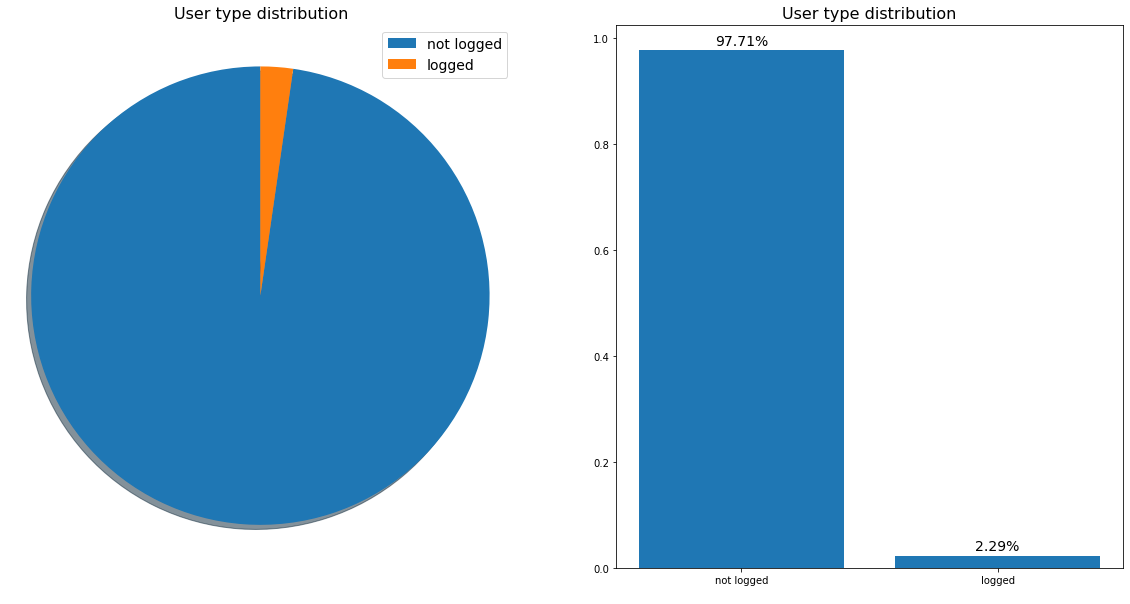

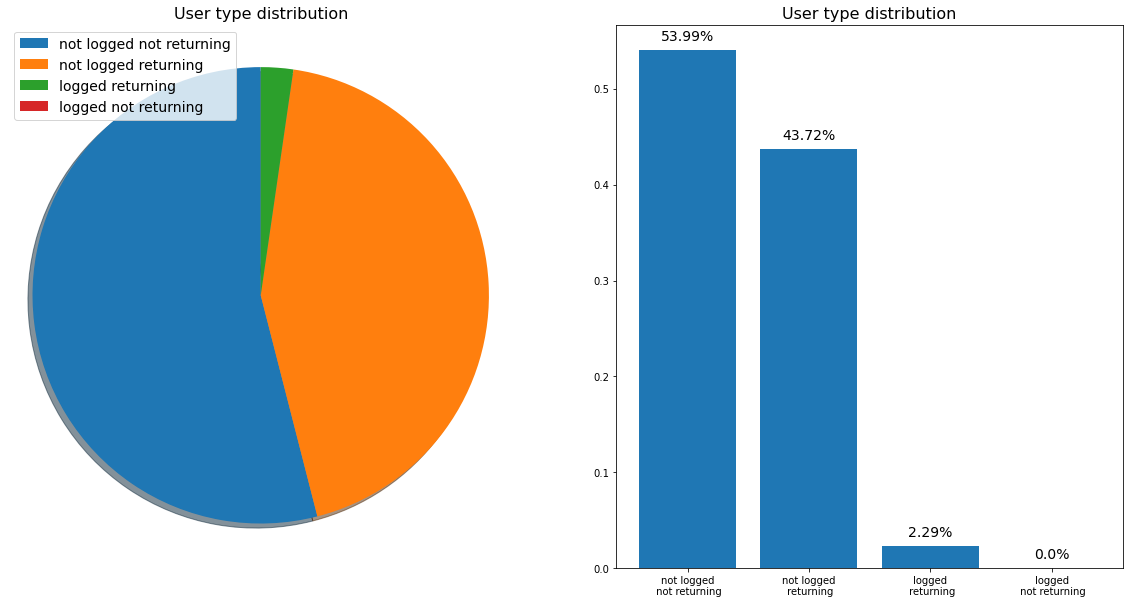

In [167]:
user_type_dis = df[["visitor_id_c","user_log_info"]].drop_duplicates()["user_log_info"].value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"User type distribution",top_n_pie=3, top_n_hist=3,xlabel="",pie_legend=True)


user_type_dis = df[["visitor_id_c","user_description"]].drop_duplicates()["user_description"].value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"User type distribution",top_n_pie=8, top_n_hist=5,xlabel="",pie_legend=True)

<a class="anchor" id="users_dis"></a>
# Session distribution by users

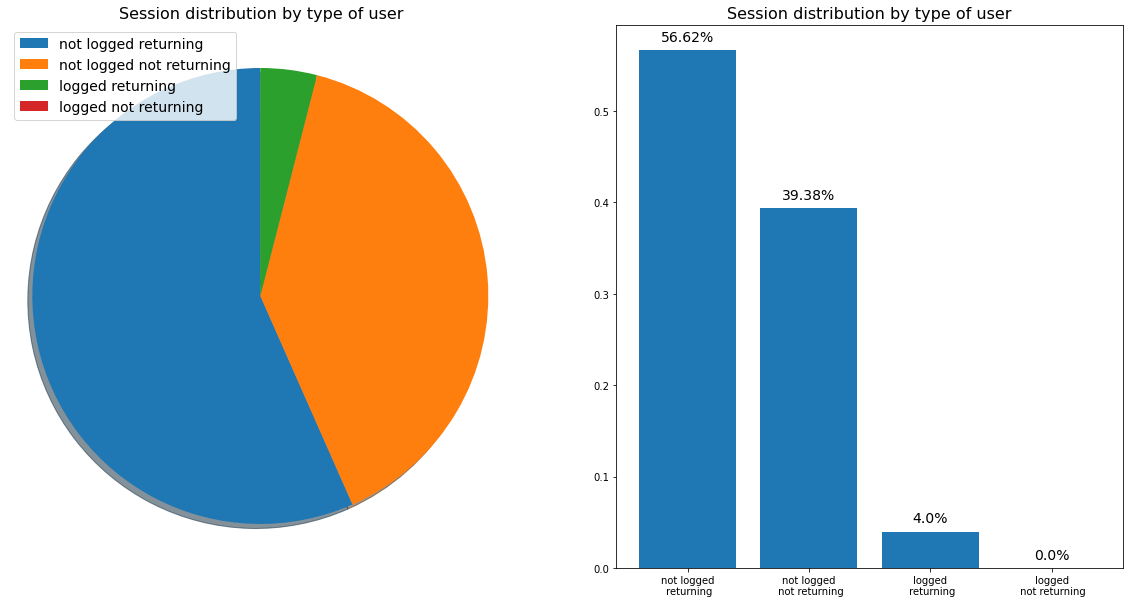

In [168]:
user_type_dis = df[["session_hk_c","visitor_id_c","user_description"]].drop_duplicates()\
                ["user_description"].value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"Session distribution by type of user",top_n_pie=8, top_n_hist=5,xlabel="",pie_legend=True)

<a class="anchor" id="users_dis"></a>
# Number of sessions by user

C:\Users\aigualam\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  


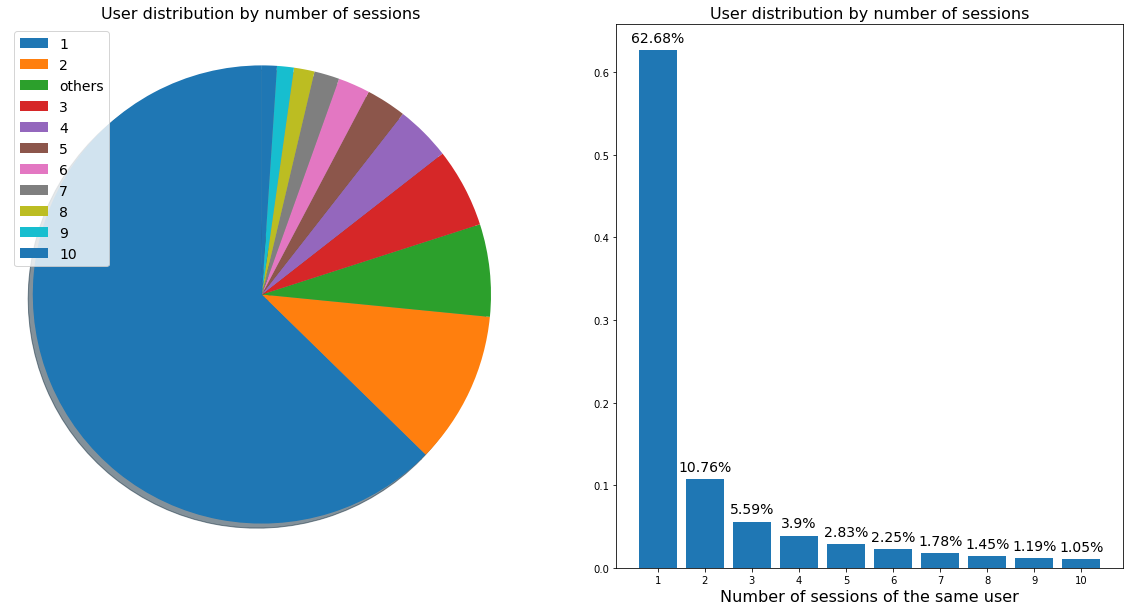

In [169]:
user_type_dis = df[["session_hk_c","visitor_id_c","user_description"]].drop_duplicates()\
                .groupby("visitor_id_c")["visitor_id_c"].transform("count").value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"User distribution by number of sessions",top_n_pie=10, top_n_hist=10,xlabel="Number of sessions of the same user",pie_legend=True)

<a class="anchor" id="users_dis"></a>
# Session distribution by apps

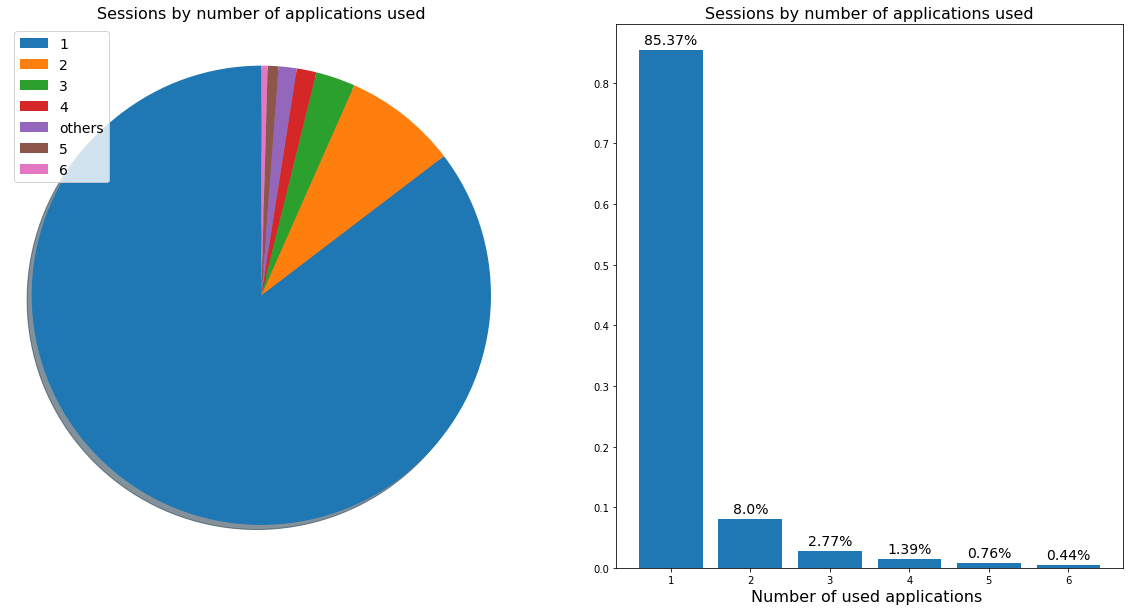

In [170]:
ses_dur_dis = df[["session_hk_c","num_apps"]].drop_duplicates()["num_apps"]\
                    .value_counts(normalize=True)
labels,data = ses_dur_dis.index, ses_dur_dis.values
plot_distribution(labels,data,"Sessions by number of applications used",top_n_pie=6, top_n_hist=6,xlabel="Number of used applications ",pie_legend=True)

<a class="anchor" id="users_dis"></a>
# Session distribution by apps depending on the type of user

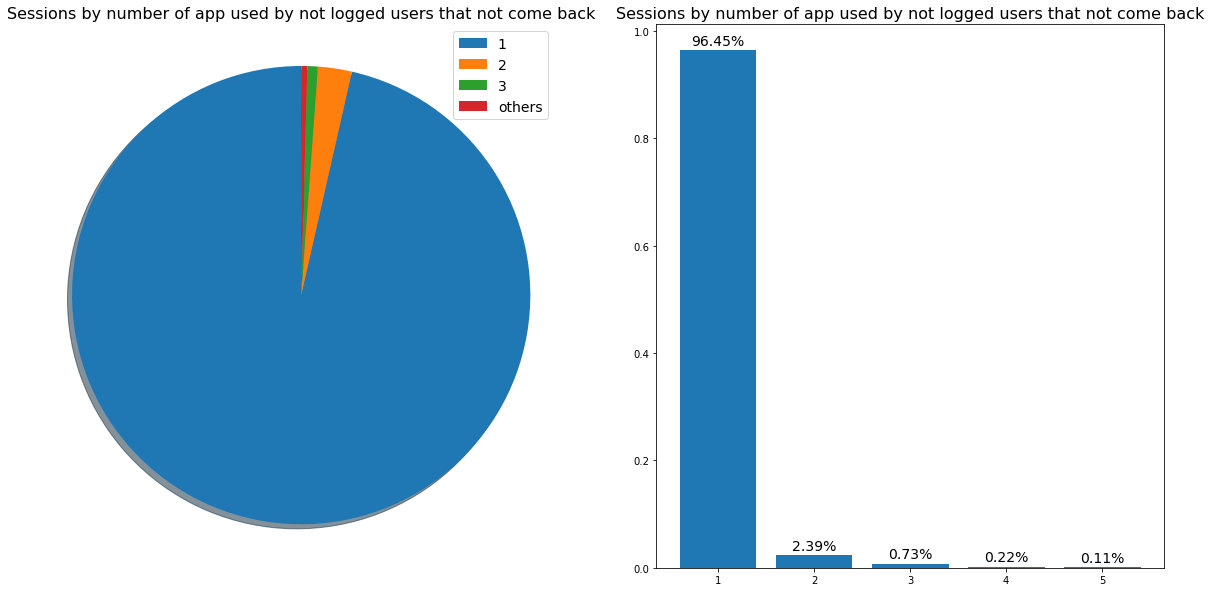

C:\Users\aigualam\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  


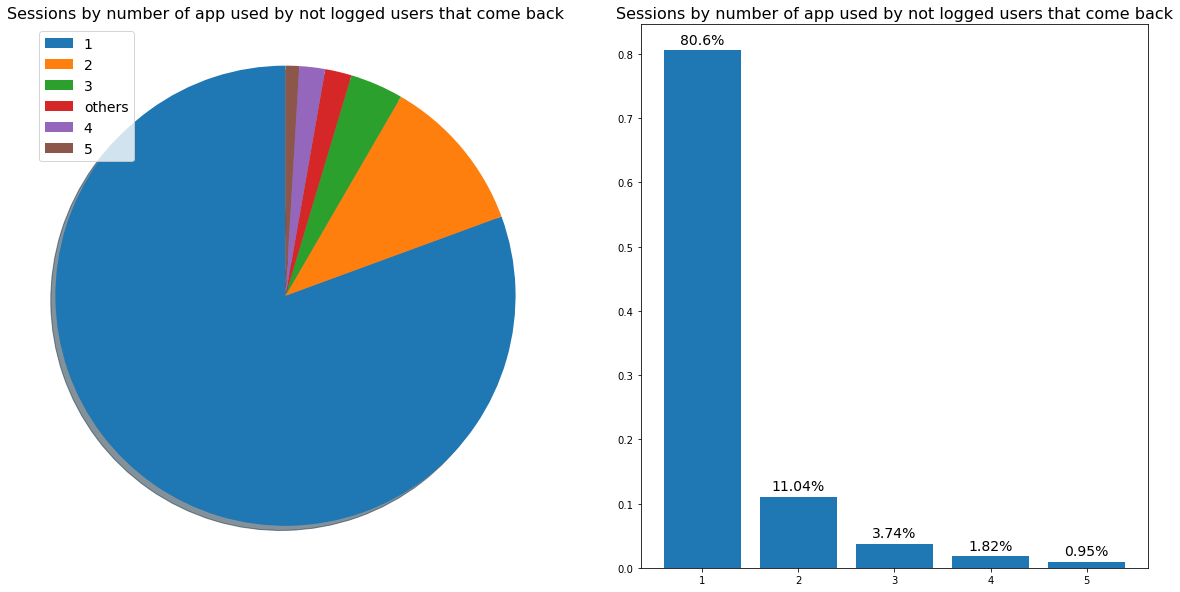

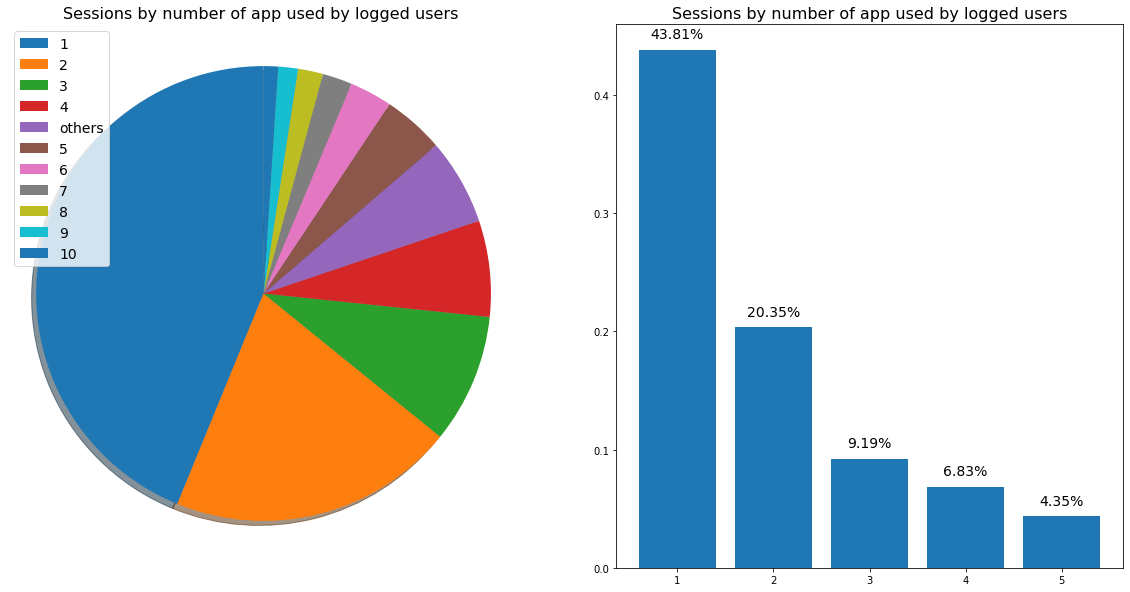

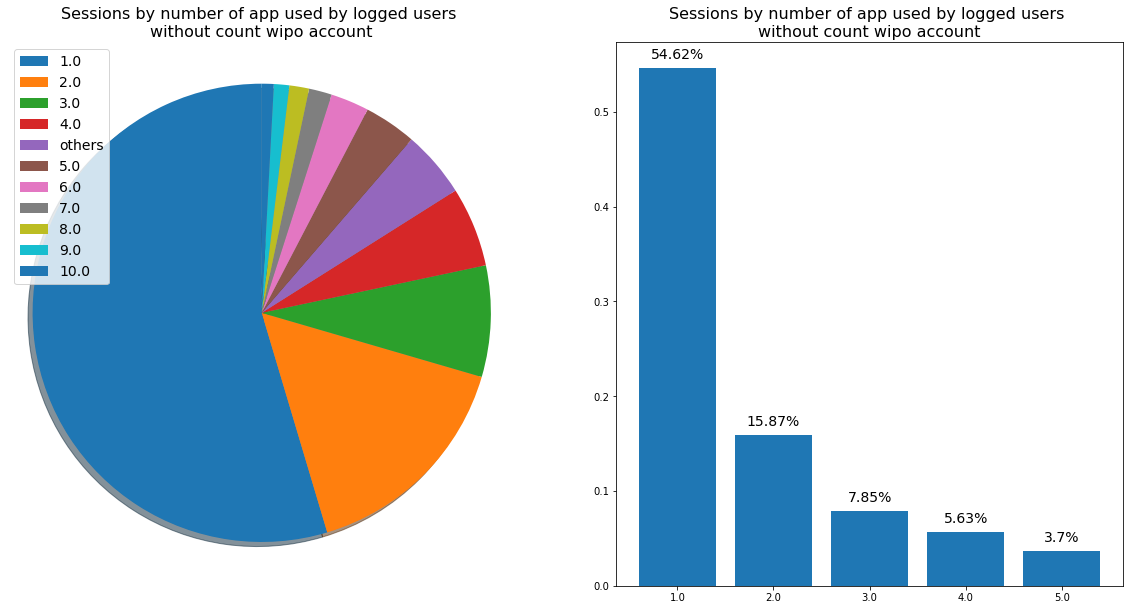

In [61]:
ses_dur_dis = df[["session_hk_c","num_apps"]].drop_duplicates()["num_apps"][(df["user_logged_treated"]==0)&(df["user_returning"]==0)]\
                    .value_counts(normalize=True)
labels,data = ses_dur_dis.index, ses_dur_dis.values
plot_distribution(labels,data,"Sessions by number of app used by not logged users that not come back",top_n_pie=3, top_n_hist=5,xlabel="",pie_legend=True)



ses_dur_dis = df[["session_hk_c","num_apps"]].drop_duplicates()["num_apps"][(df["user_logged_treated"]==0)&(df["user_returning"]==1)]\
                    .value_counts(normalize=True)
labels,data = ses_dur_dis.index, ses_dur_dis.values
plot_distribution(labels,data,"Sessions by number of app used by not logged users that come back",top_n_pie=5, top_n_hist=5,xlabel="",pie_legend=True)


ses_dur_dis = df[["session_hk_c","num_apps"]].drop_duplicates()["num_apps"][(df["user_logged_treated"]==1)]\
                    .value_counts(normalize=True)
labels,data = ses_dur_dis.index, ses_dur_dis.values
plot_distribution(labels,data,"Sessions by number of app used by logged users",top_n_pie=10, top_n_hist=5,xlabel="",pie_legend=True)


ses_dur_dis = df[["session_hk_c","num_apps_without_wipo_account"]].drop_duplicates()["num_apps_without_wipo_account"][(df["user_logged_treated"]==1)]\
                    .value_counts(normalize=True)
labels,data = ses_dur_dis.index, ses_dur_dis.values
plot_distribution(labels,data,"Sessions by number of app used by logged users \nwithout count wipo account",top_n_pie=10, top_n_hist=5,xlabel="",pie_legend=True)

<a class="anchor" id="users_dis"></a>
# Session distribution by duration

C:\Users\aigualam\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  


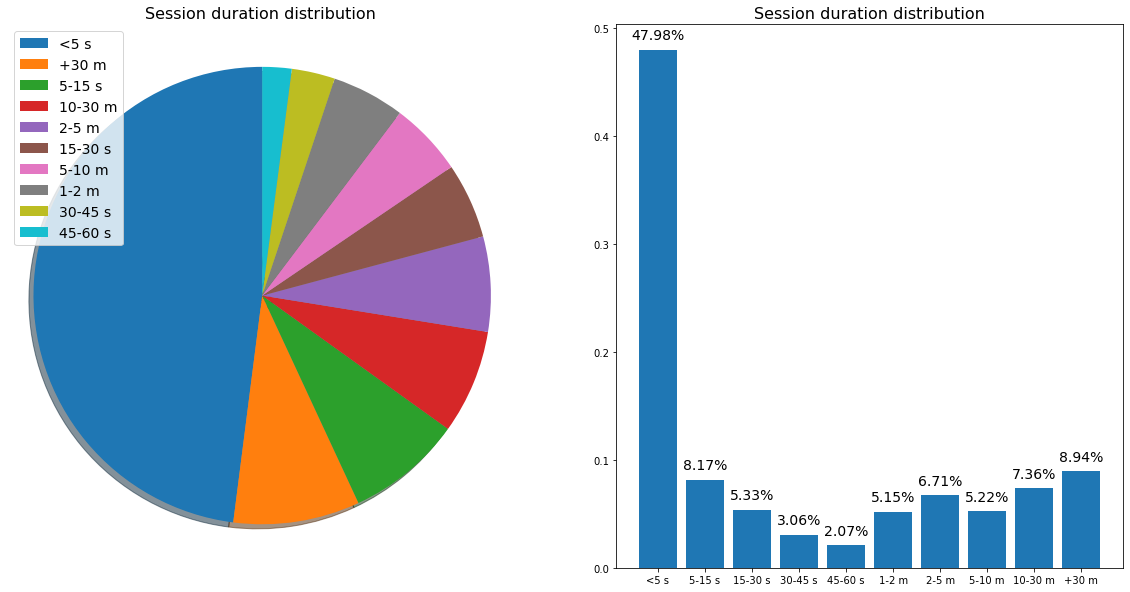

In [172]:
ses_dur_dis = df[["session_hk_c","session_duration_range"]].drop_duplicates()["session_duration_range"]\
                    .value_counts(normalize=True)
labels,data  = sort_serie_with_duration_ranges(ses_dur_dis)
plot_distribution(labels,data,"Session duration distribution",top_n_pie=10, top_n_hist=10,xlabel="",pie_legend=True)

<a class="anchor" id="users_dis"></a>
# Session distribution by duration depending on type of user

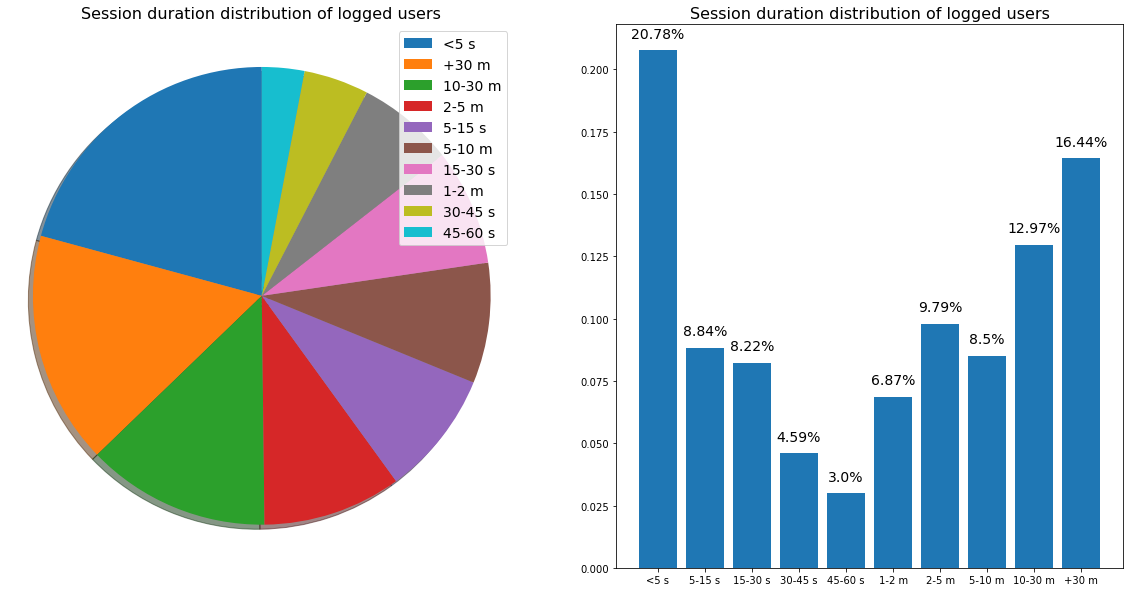

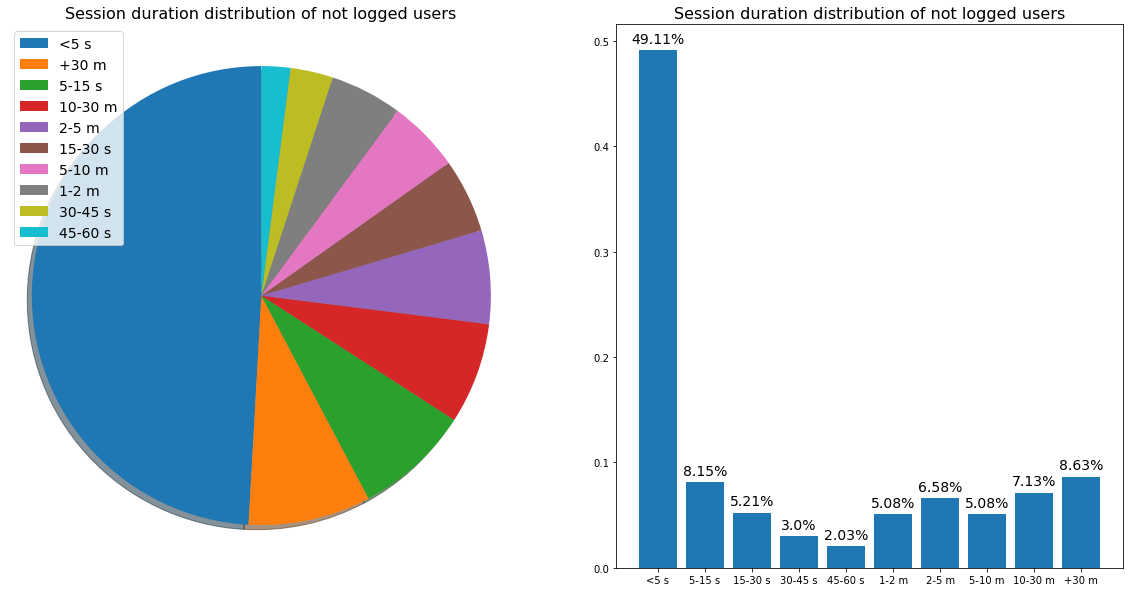

In [173]:
ses_dur_dis = df[["session_hk_c","session_duration_range"]][df["user_logged_treated"]==1].drop_duplicates()["session_duration_range"]\
                    .value_counts(normalize=True)
labels,data  = sort_serie_with_duration_ranges(ses_dur_dis)
plot_distribution(labels,data,"Session duration distribution of logged users",top_n_pie=10, top_n_hist=10,xlabel="",pie_legend=True,bar_annot_extra=0.005)


ses_dur_dis = df[["session_hk_c","session_duration_range"]][df["user_logged_treated"]==0].drop_duplicates()["session_duration_range"]\
                    .value_counts(normalize=True)
labels,data  = sort_serie_with_duration_ranges(ses_dur_dis)
plot_distribution(labels,data,"Session duration distribution of not logged users",top_n_pie=10, top_n_hist=10,xlabel="",pie_legend=True,bar_annot_extra=0.007)

<a class="anchor" id="event_dur_comparison"></a>
## Event durations before and after apply rules

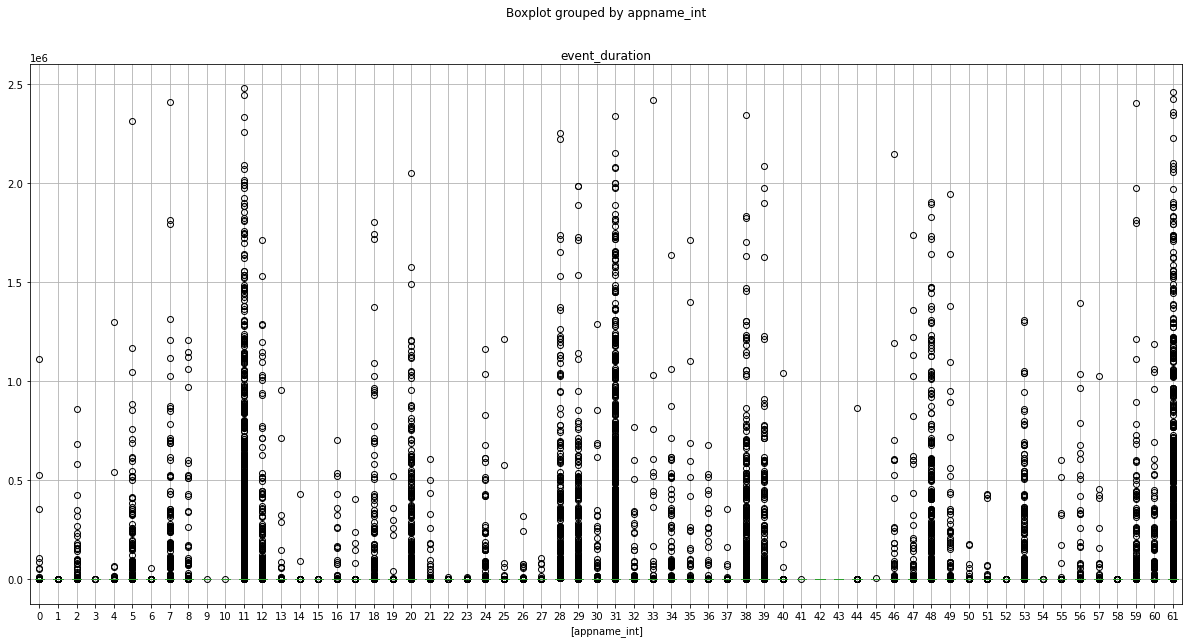

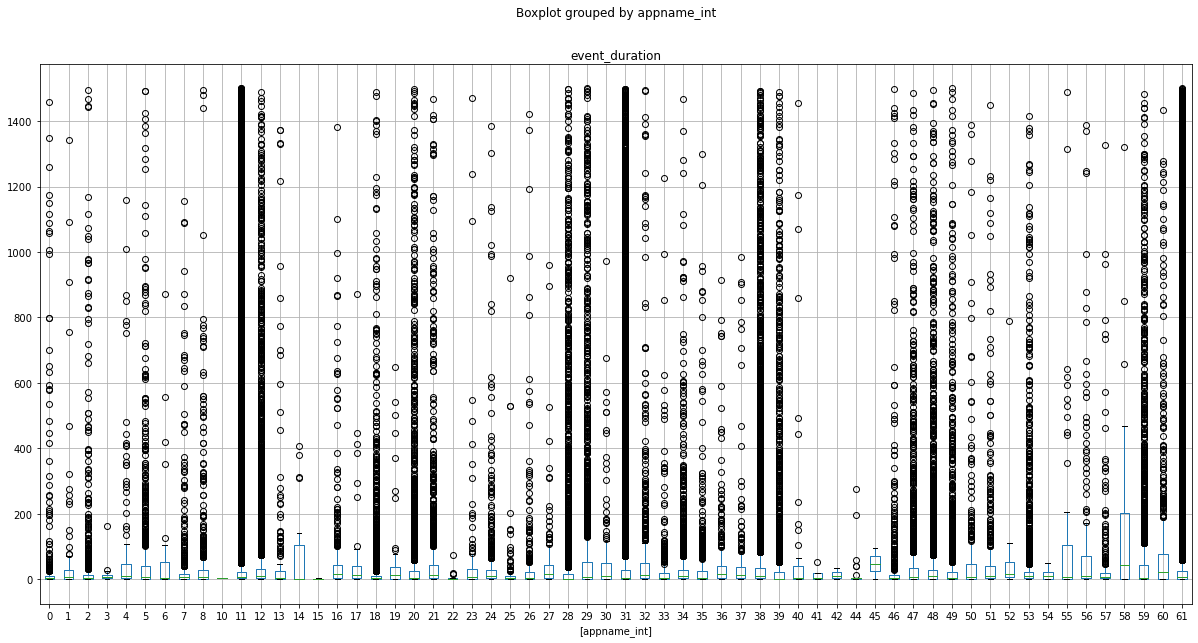

In [174]:
boxplot = df_events.boxplot(column=['event_duration'], by=['appname_int'])
boxplot = filtered_df_events.boxplot(column=['event_duration'], by=['appname_int'])

<a class="anchor" id="apps_dur_comparison"></a>
## Apps durations before and after apply rules

Text(0.5, 0, 'Application id')

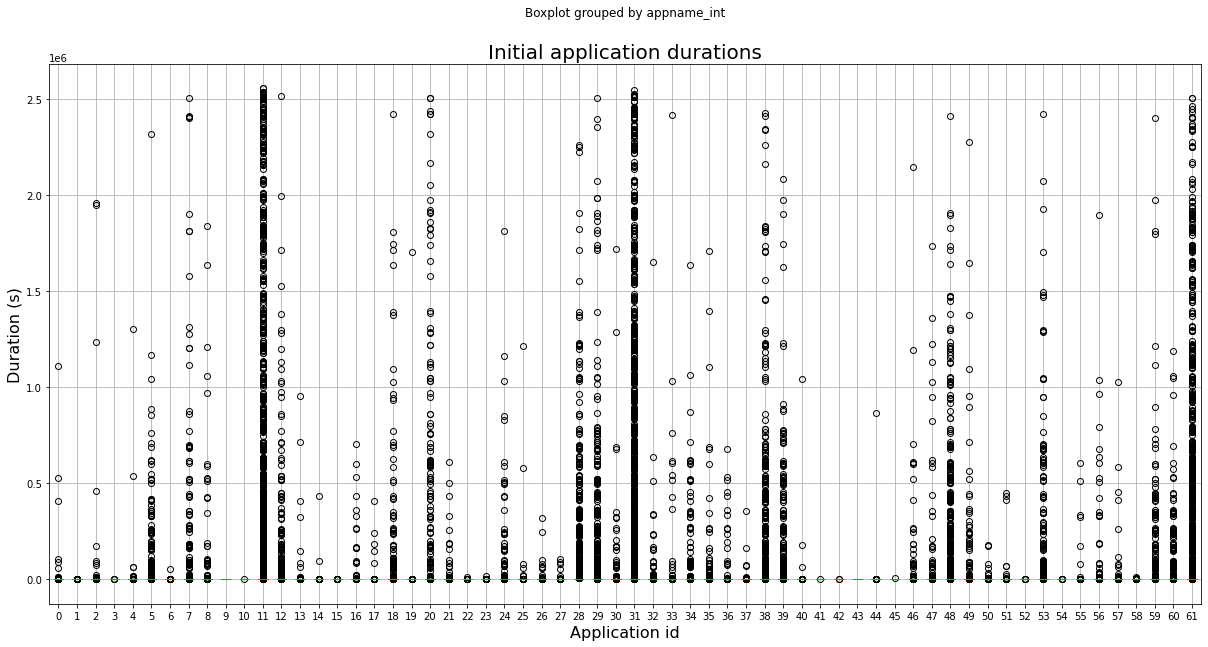

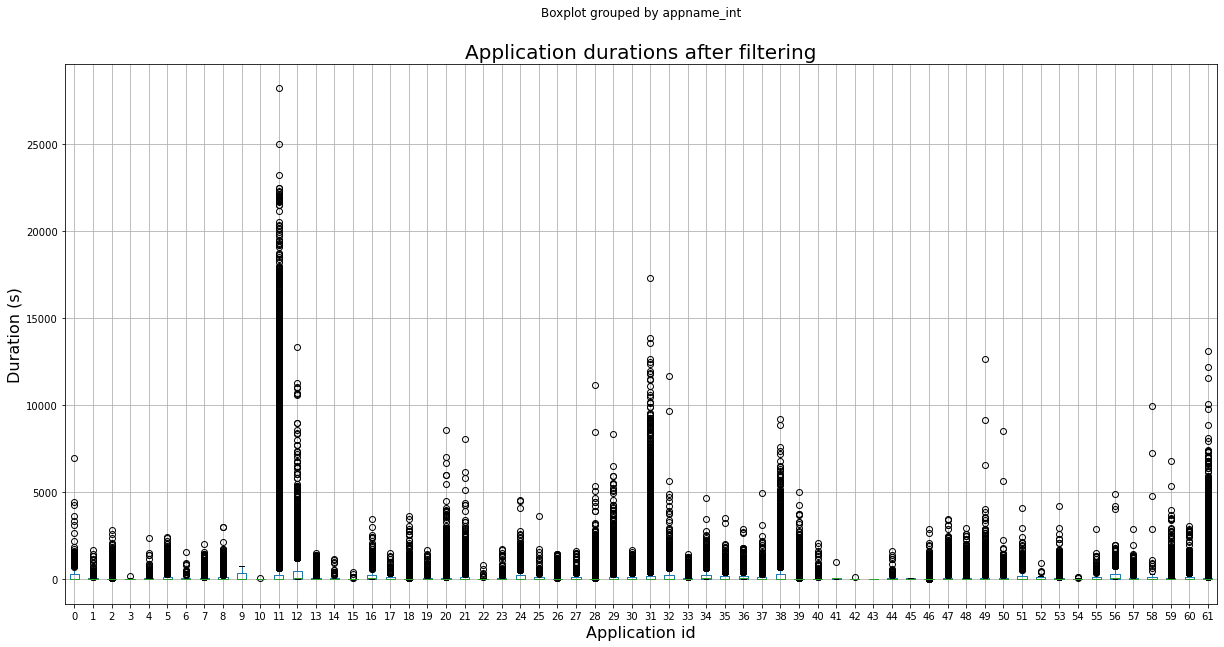

In [175]:
boxplot = df.boxplot(column=['calculated_app_duration'], by=['appname_int'])
plt.title("Initial application durations",fontsize=20)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)



boxplot = filtered_df.boxplot(column=['calculated_app_duration'], by=['appname_int'])
plt.title("Application durations after filtering",fontsize=20)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)

<a class="anchor" id="app_mean_duration"></a>
## Applications mean/median durations

Text(0.5, 1.0, 'Mean Event duration (for all sessions)')

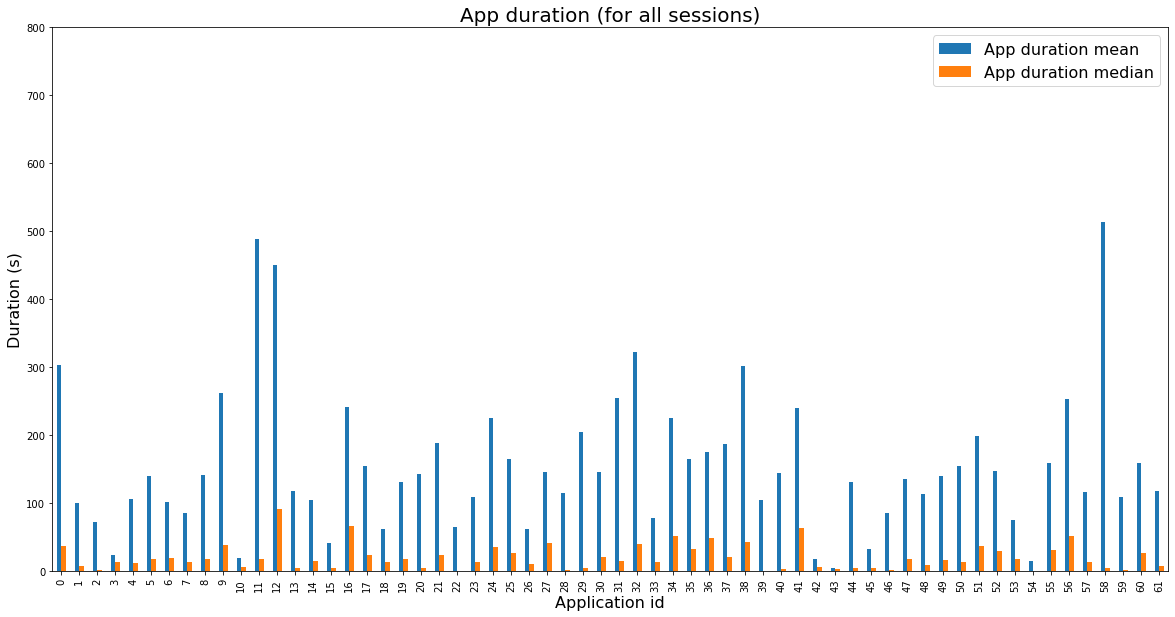

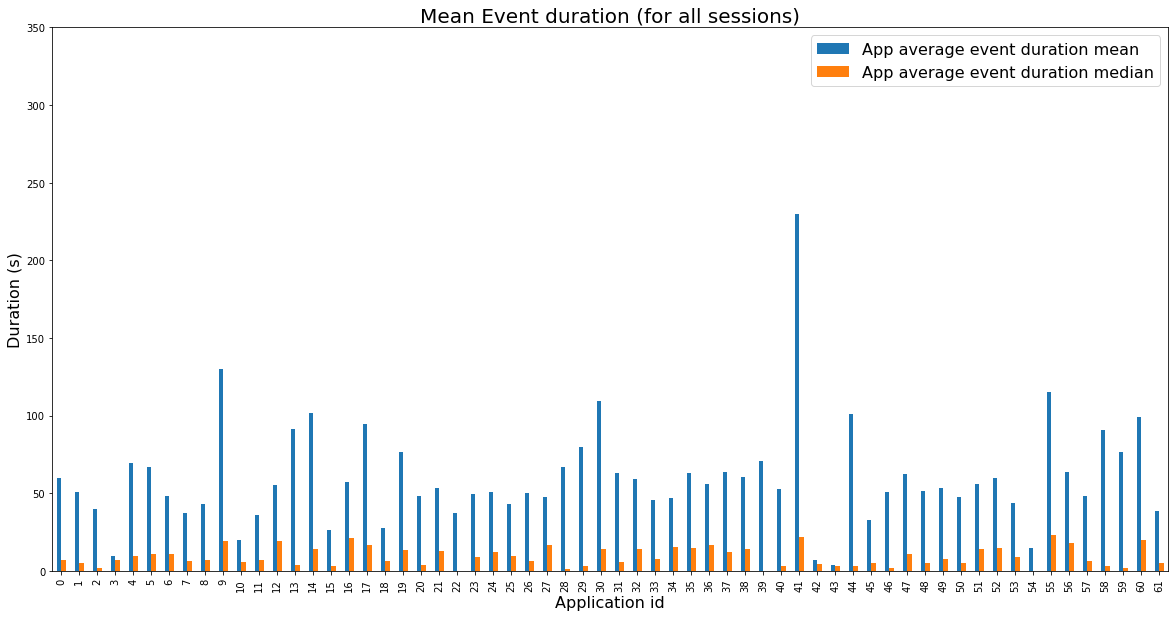

In [176]:
aux = filtered_df[["appname_int","calculated_app_duration","app_mean_event_duration"]]\
                .groupby("appname_int").agg(["mean","median",pd.Series.mode])


aux.plot( y=[("calculated_app_duration","mean"),("calculated_app_duration","median")], kind="bar")
plt.title("App duration (for all sessions)",fontsize=20)
plt.legend(["App duration mean", "App duration median"],fontsize=16)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)
plt.ylim(top=800)


aux.plot( y=[("app_mean_event_duration","mean"),("app_mean_event_duration","median")], kind="bar")
plt.legend(["App average event duration mean", "App average event duration median"],fontsize=16)
plt.ylim(top=350)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)
plt.title("Mean Event duration (for all sessions)",fontsize=20)

Text(0.5, 1.0, 'Mean Event duration (for sessions with only one application)')

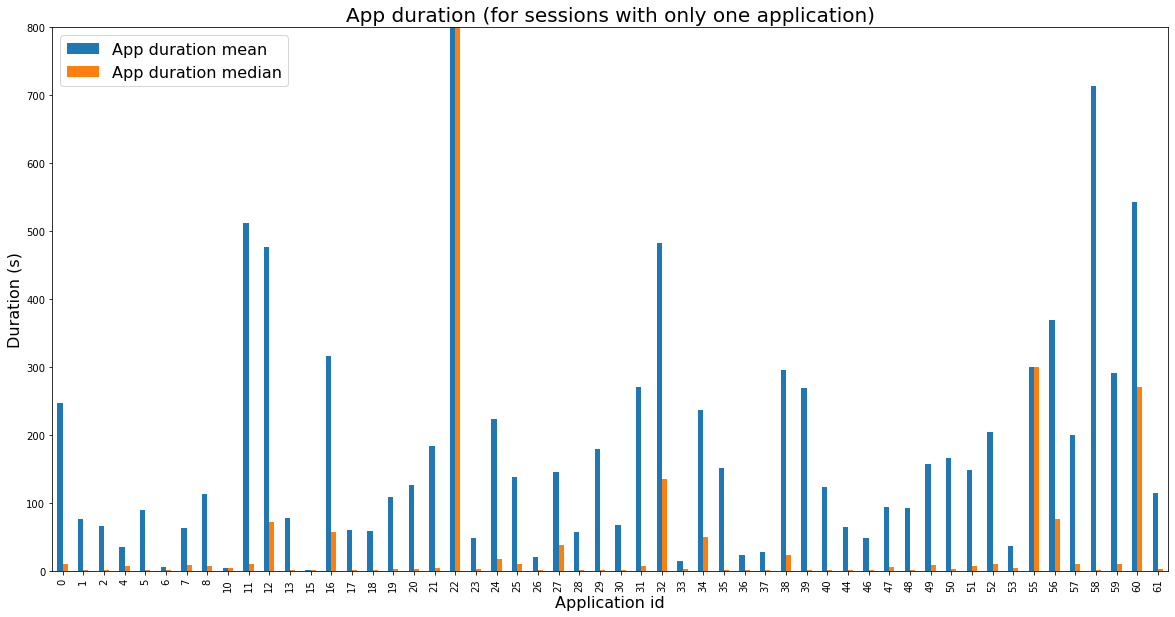

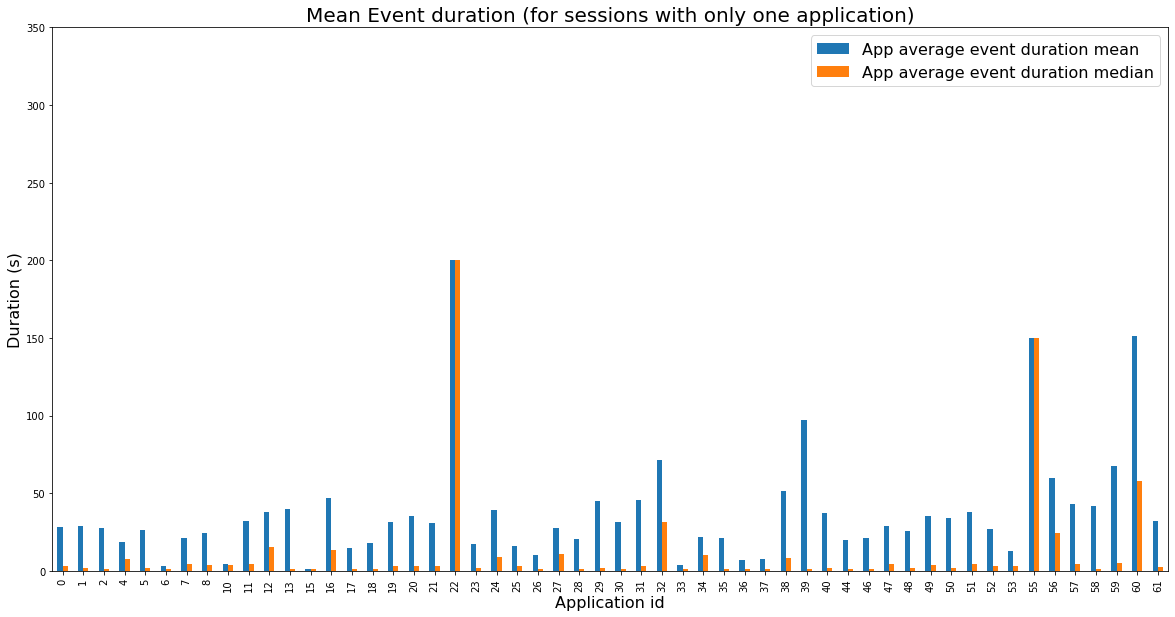

In [177]:
aux = filtered_df[["appname_int","calculated_app_duration","app_mean_event_duration"]]\
                [filtered_df["num_apps"]==1]\
                .groupby("appname_int").agg(["mean","median",pd.Series.mode])


aux.plot( y=[("calculated_app_duration","mean"),("calculated_app_duration","median")], kind="bar")
plt.title("App duration (for sessions with only one application)",fontsize=20)
plt.legend(["App duration mean", "App duration median"],fontsize=16)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)
plt.ylim(top=800)


aux.plot( y=[("app_mean_event_duration","mean"),("app_mean_event_duration","median")], kind="bar")
plt.legend(["App average event duration mean", "App average event duration median"],fontsize=16)
plt.ylim(top=350)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)
plt.title("Mean Event duration (for sessions with only one application)",fontsize=20)

Text(0.5, 1.0, 'Mean Event duration (for sessions with two applications)')

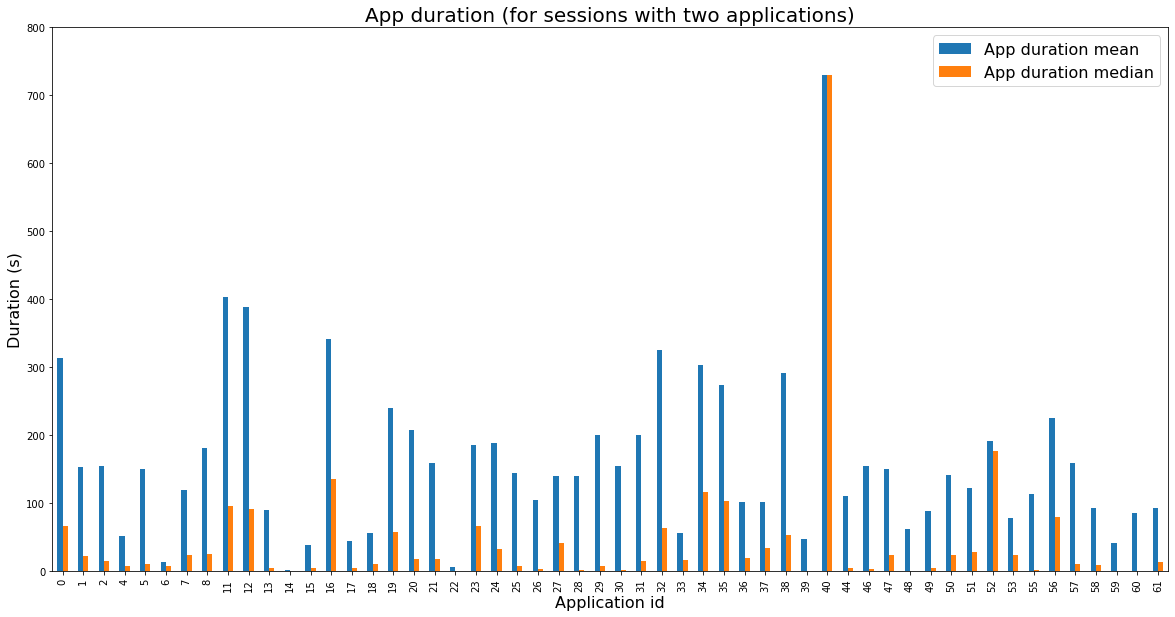

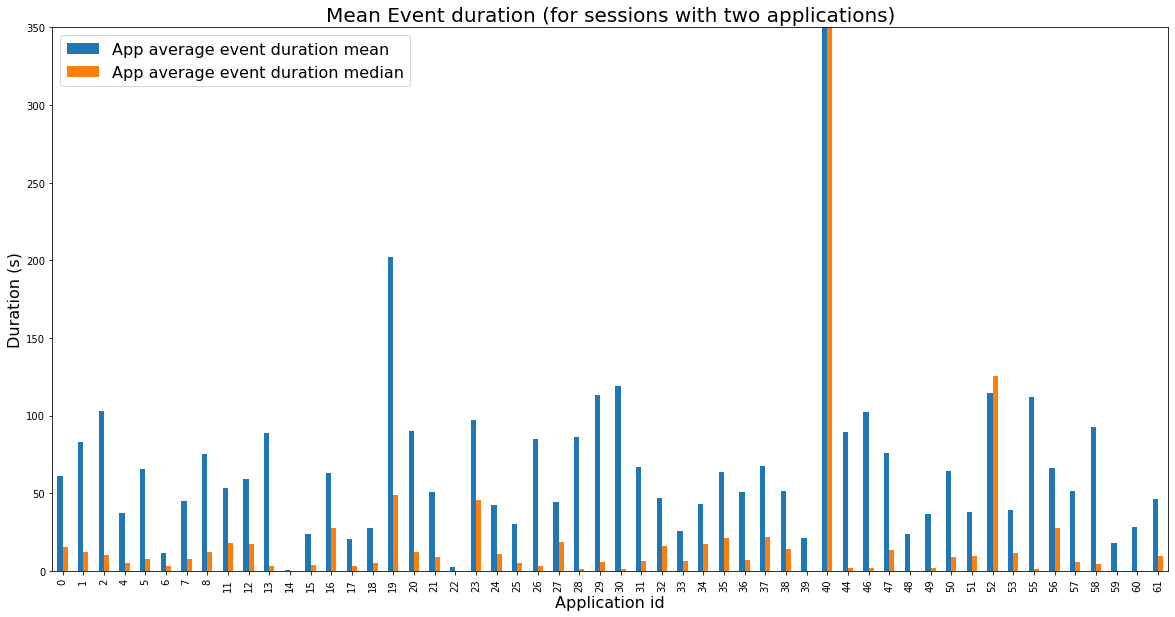

In [178]:
aux = filtered_df[["appname_int","calculated_app_duration","app_mean_event_duration"]]\
                [filtered_df["num_apps"]==2]\
                .groupby("appname_int").agg(["mean","median"])


aux.plot( y=[("calculated_app_duration","mean"),("calculated_app_duration","median")], kind="bar")
plt.title("App duration (for sessions with two applications)",fontsize=20)
plt.legend(["App duration mean", "App duration median"],fontsize=16)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)
plt.ylim(top=800)


aux.plot( y=[("app_mean_event_duration","mean"),("app_mean_event_duration","median")], kind="bar")
plt.legend(["App average event duration mean", "App average event duration median"],fontsize=16)
plt.ylim(top=350)
plt.ylabel("Duration (s)",fontsize=16)
plt.xlabel("Application id",fontsize=16)
plt.title("Mean Event duration (for sessions with two applications)",fontsize=20)

<a class="anchor" id="plots_after_rules"></a>
# Plots after apply rules

<a class="anchor" id="users_dis"></a>
### Sessions distribution by apps after remove outliers and session with non human behaviour

After remove outliers, we can see that most of the sessions use only one app.

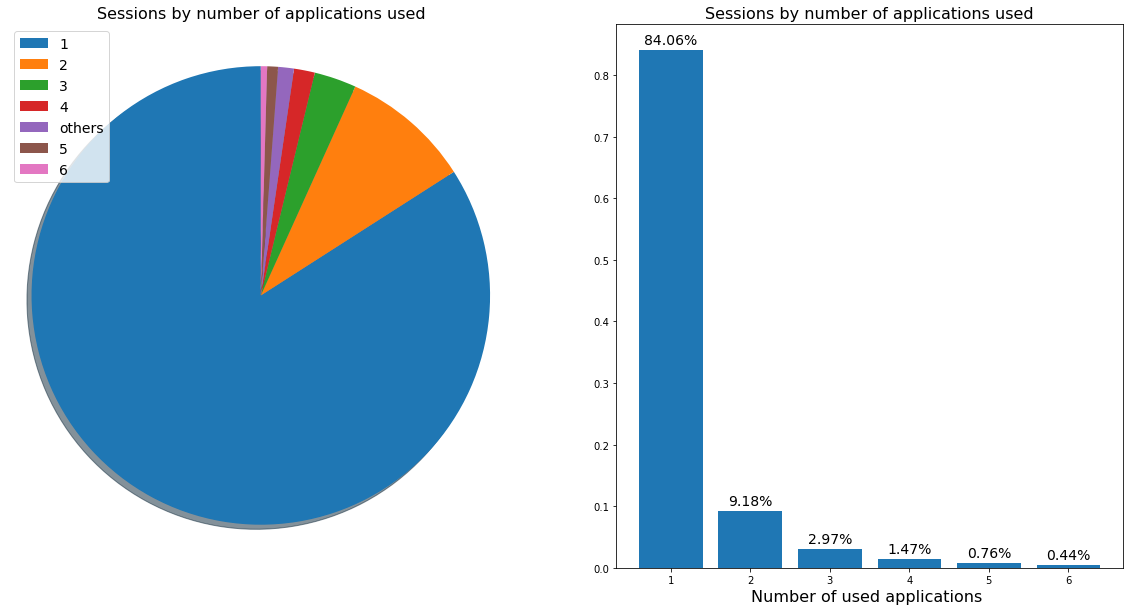

In [179]:
ses_dur_dis = filtered_df[["session_hk_c","num_apps"]].drop_duplicates()["num_apps"]\
                    .value_counts(normalize=True)
labels,data = ses_dur_dis.index, ses_dur_dis.values
plot_distribution(labels,data,"Sessions by number of applications used",top_n_pie=6, top_n_hist=6,xlabel="Number of used applications ",pie_legend=True)

# SESSION DURATION DISTRIBUTION

C:\Users\aigualam\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  


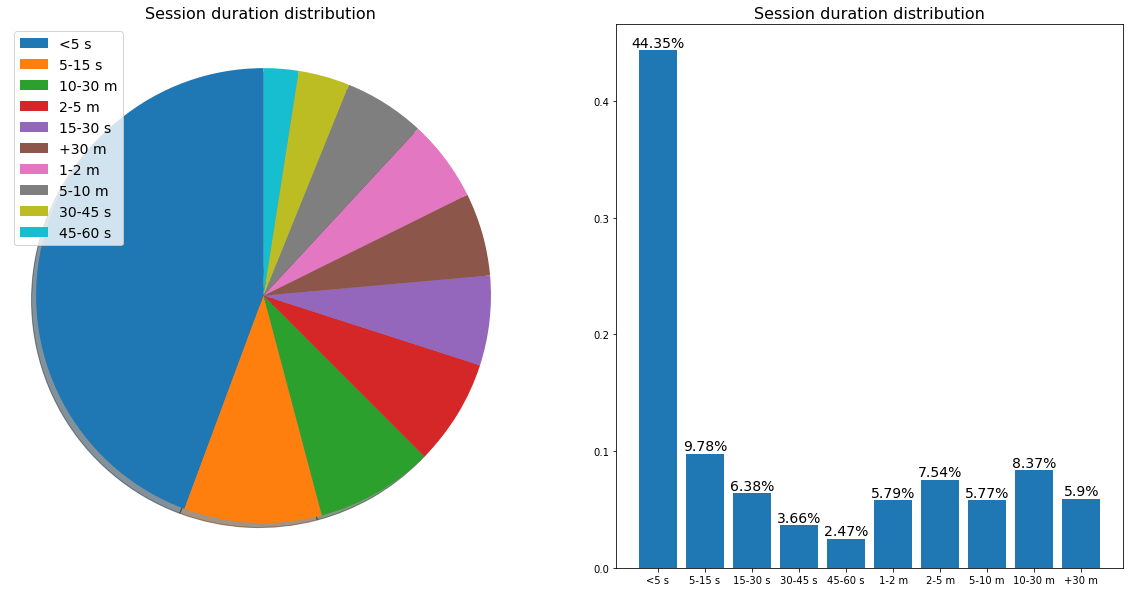

In [180]:
ses_dur_dis = filtered_df[["session_hk_c","session_duration_range"]].drop_duplicates()["session_duration_range"]\
                    .value_counts(normalize=True)
labels,data  = sort_serie_with_duration_ranges(ses_dur_dis)
plot_distribution(labels,data,"Session duration distribution",top_n_pie=10, top_n_hist=10,xlabel="",pie_legend=True,bar_annot_extra=0.003)

# SESSION DISTRIBUTION BY TYPE OF USER

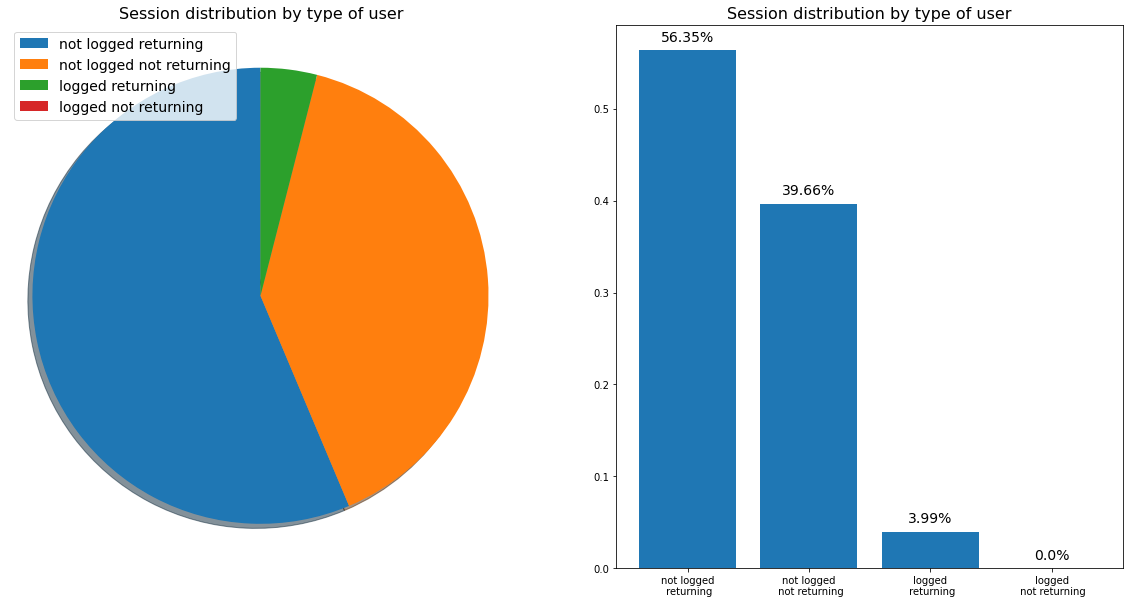

In [181]:
user_type_dis = filtered_df[["session_hk_c","visitor_id_c","user_description"]].drop_duplicates()\
                ["user_description"].value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"Session distribution by type of user",top_n_pie=8, top_n_hist=5,xlabel="",pie_legend=True)

# NUMBER OF SESSIONS BY USER

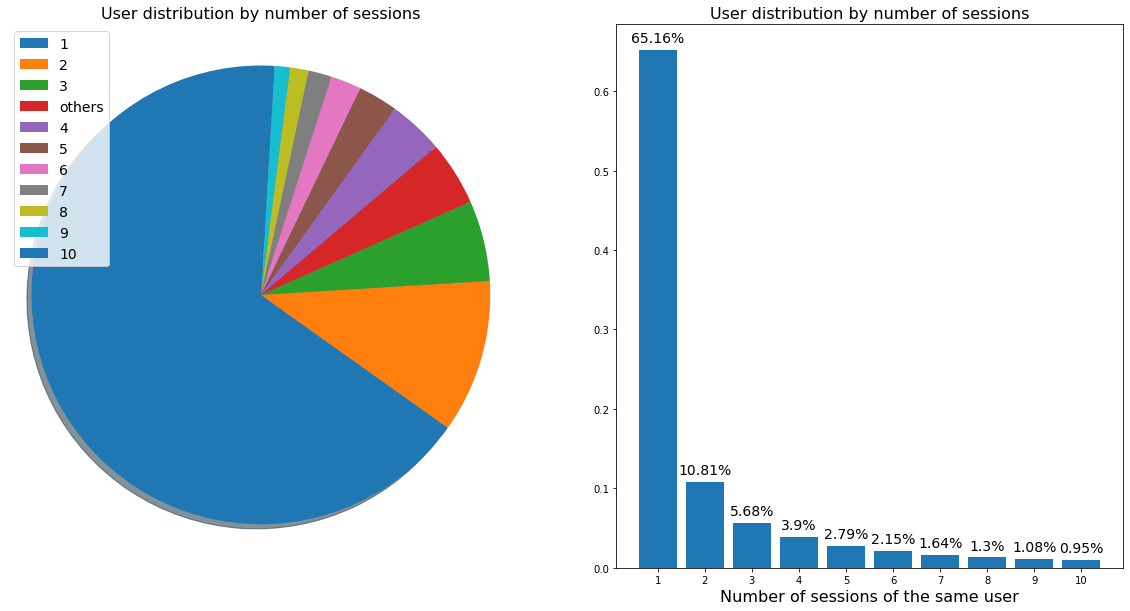

In [182]:
user_type_dis = filtered_df[["session_hk_c","visitor_id_c","user_description"]].drop_duplicates()\
                .groupby("visitor_id_c")["visitor_id_c"].transform("count").value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"User distribution by number of sessions",top_n_pie=10, top_n_hist=10,xlabel="Number of sessions of the same user",pie_legend=True)

<a class="anchor" id="users_dis"></a>
# Applications distribution after filtering outliers depending on the number of applications used on a session

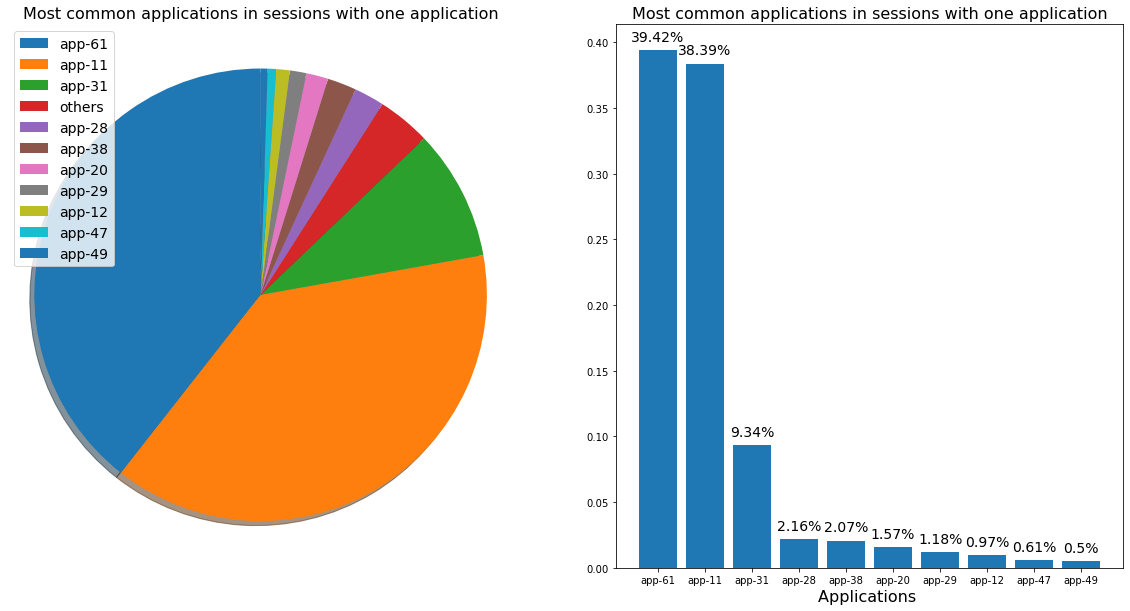

C:\Users\aigualam\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  


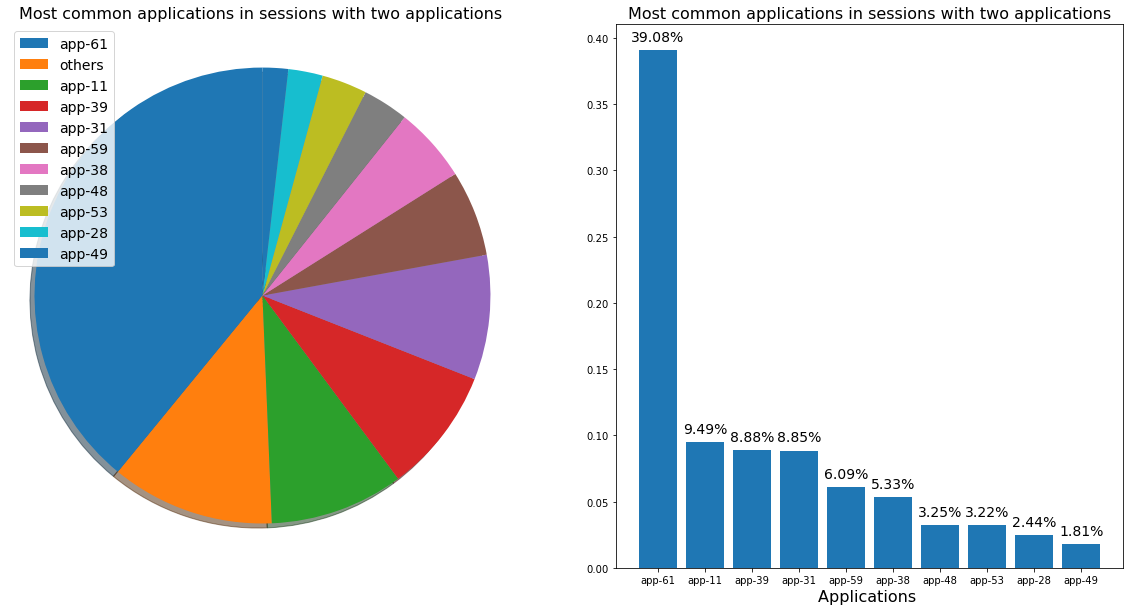

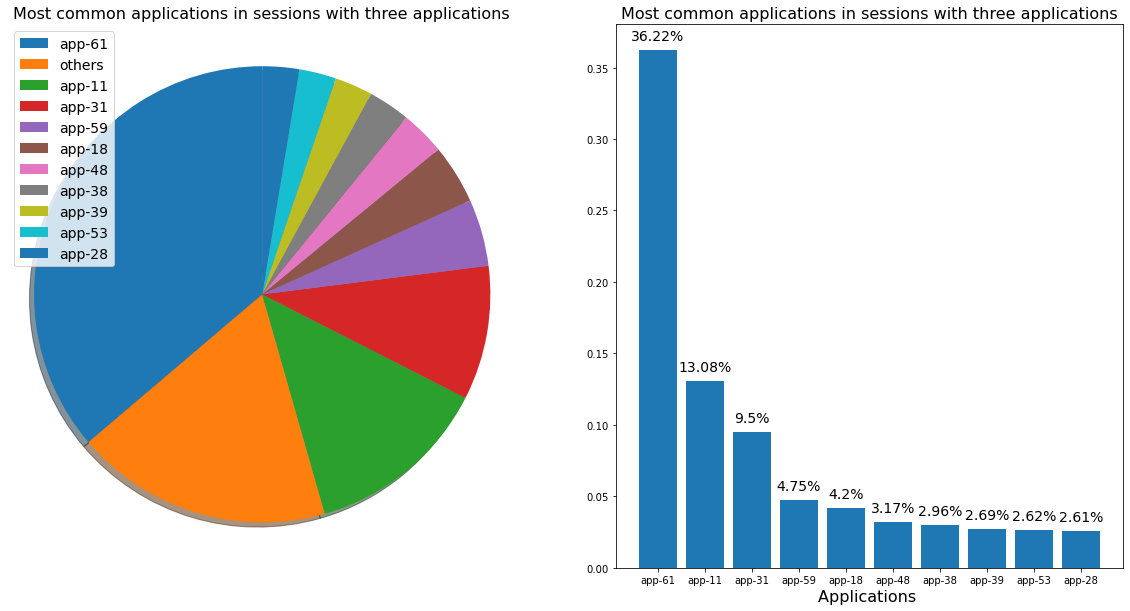

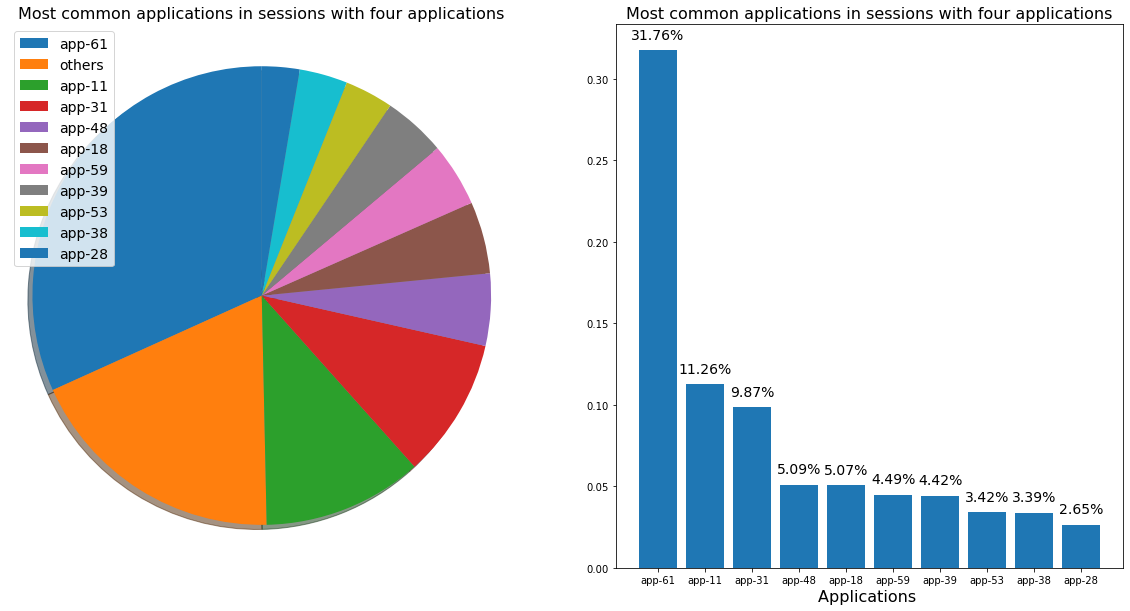

In [183]:
app_dis = filtered_df[filtered_df["num_apps"]==1][["appname_c"]]["appname_c"].value_counts(normalize=True)
labels,data = app_dis.index, app_dis.values
plot_distribution(labels,data,"Most common applications in sessions with one application",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True, bar_annot_extra=0.007)


app_dis = filtered_df[filtered_df["num_apps"]==2][["appname_c"]]["appname_c"].value_counts(normalize=True)
labels,data = app_dis.index, app_dis.values
plot_distribution(labels,data,"Most common applications in sessions with two applications",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True, bar_annot_extra=0.007)


app_dis = filtered_df[filtered_df["num_apps"]==3][["appname_c"]]["appname_c"].value_counts(normalize=True)
labels,data = app_dis.index, app_dis.values
plot_distribution(labels,data,"Most common applications in sessions with three applications",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True, bar_annot_extra=0.007)



app_dis = filtered_df[filtered_df["num_apps"]==4][["appname_c"]]["appname_c"].value_counts(normalize=True)
labels,data = app_dis.index, app_dis.values
plot_distribution(labels,data,"Most common applications in sessions with four applications",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True,bar_annot_extra=0.007)

<a class="anchor" id="users_dis"></a>
# Users distribution after filtering outliers depending on the number of applications used on a session

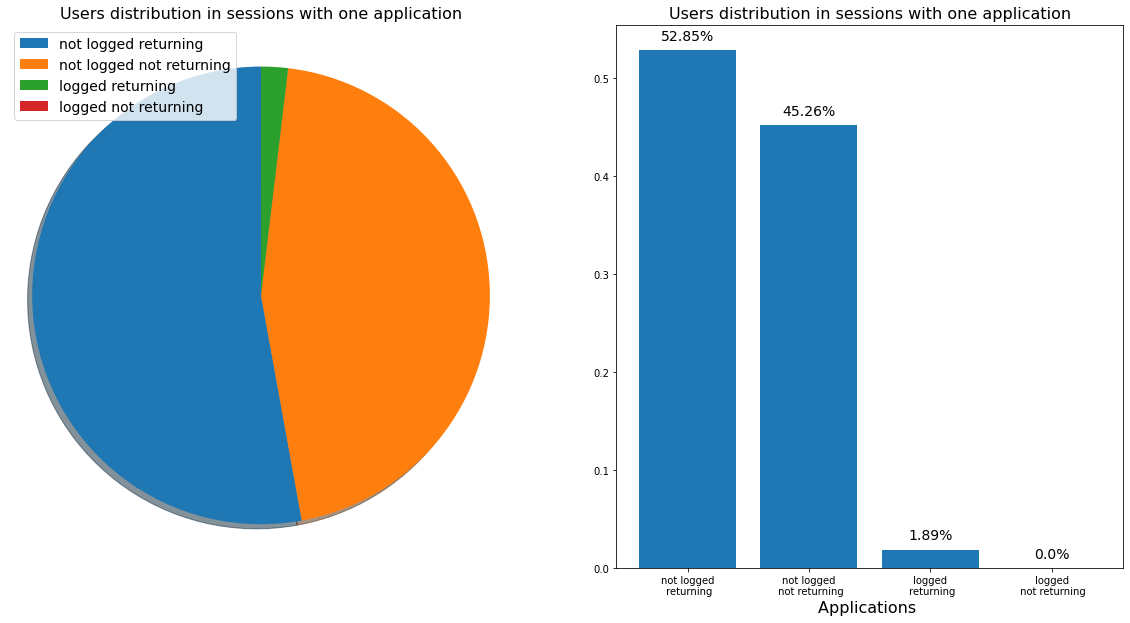

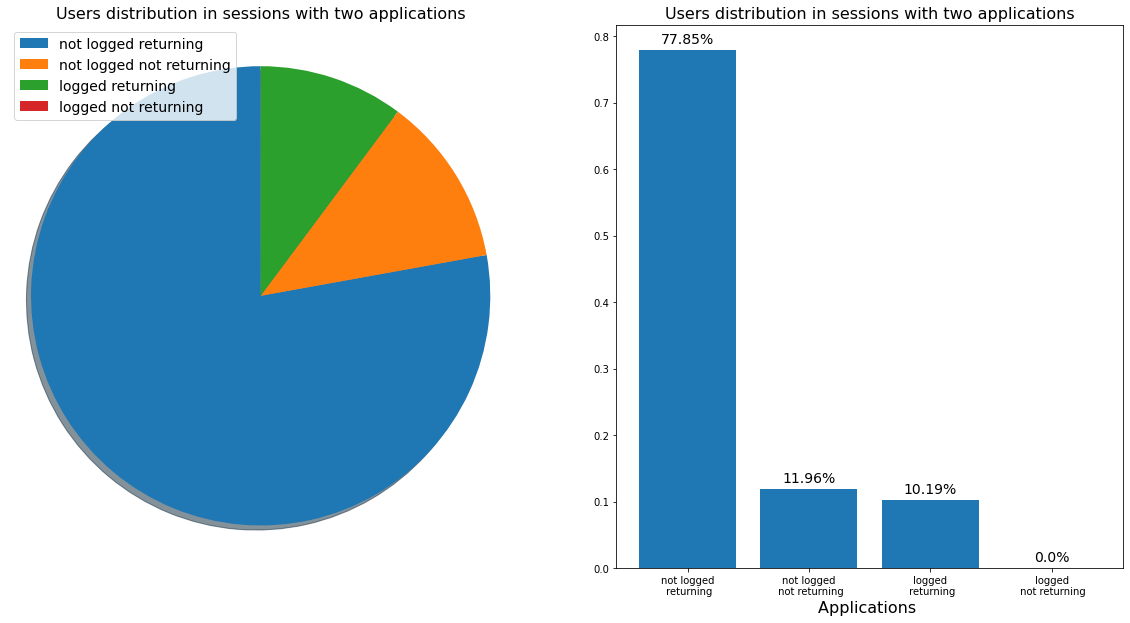

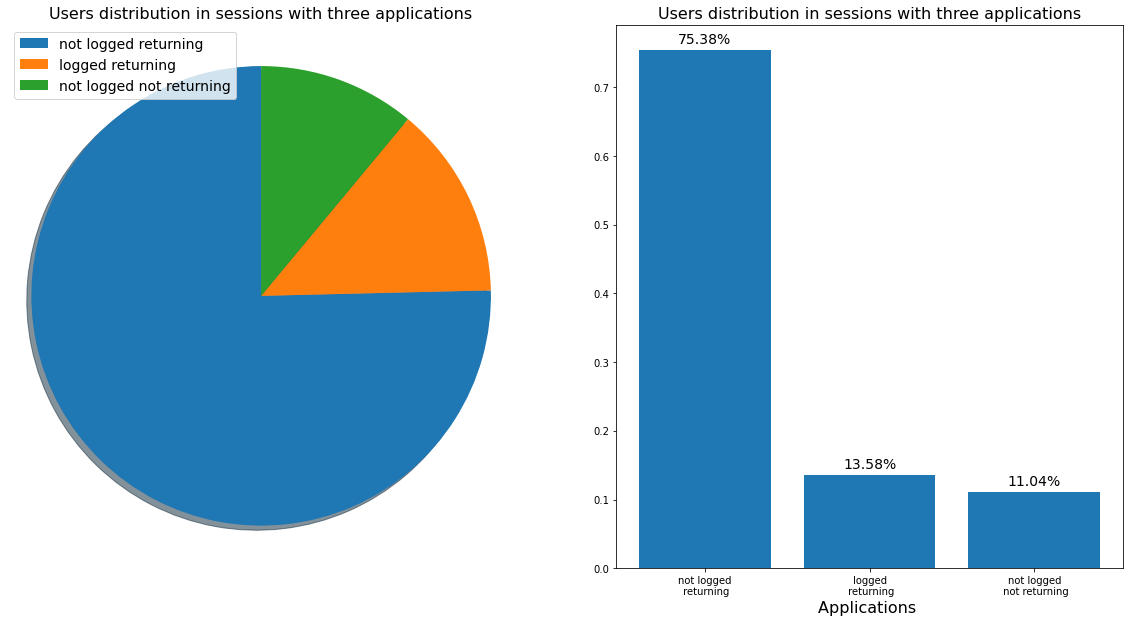

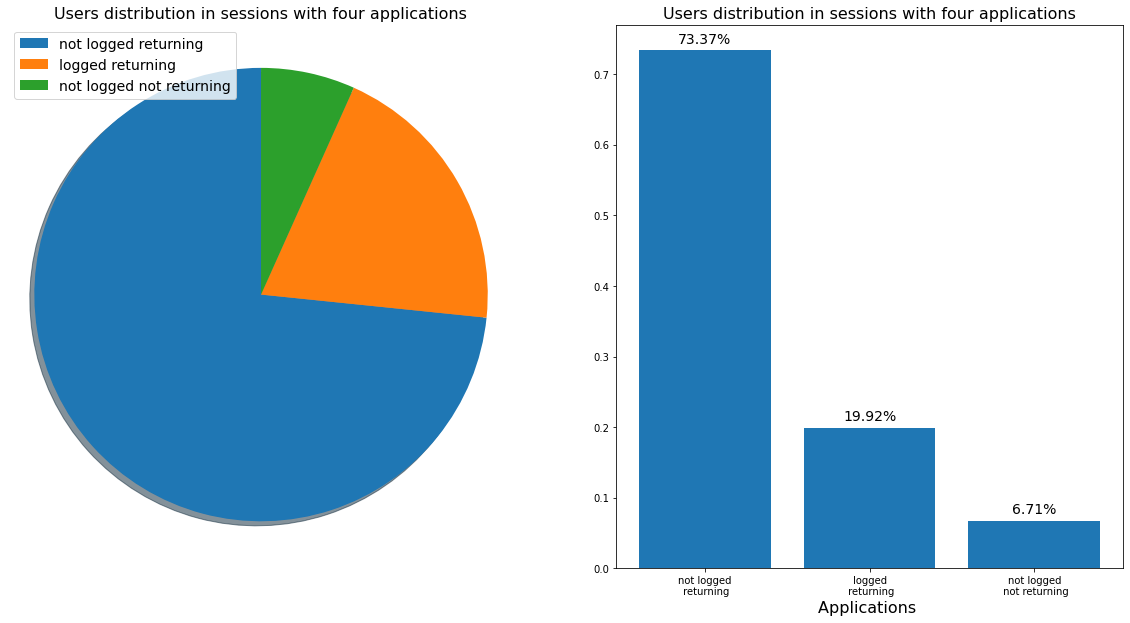

In [184]:
user_dis = filtered_df[["session_hk_c","user_description"]][filtered_df["num_apps"]==1]\
                    .drop_duplicates()["user_description"]\
                    .value_counts(normalize=True)
labels,data = user_dis.index, user_dis.values
plot_distribution(labels,data,"Users distribution in sessions with one application",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True)



user_dis = filtered_df[["session_hk_c","user_description"]][filtered_df["num_apps"]==2]\
                    .drop_duplicates()["user_description"]\
                    .value_counts(normalize=True)
labels,data = user_dis.index, user_dis.values
plot_distribution(labels,data,"Users distribution in sessions with two applications",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True)



user_dis = filtered_df[["session_hk_c","user_description"]][filtered_df["num_apps"]==3]\
                    .drop_duplicates()["user_description"]\
                    .value_counts(normalize=True)
labels,data = user_dis.index, user_dis.values
plot_distribution(labels,data,"Users distribution in sessions with three applications",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True)




user_dis = filtered_df[["session_hk_c","user_description"]][filtered_df["num_apps"]==4]\
                    .drop_duplicates()["user_description"]\
                    .value_counts(normalize=True)
labels,data = user_dis.index, user_dis.values
plot_distribution(labels,data,"Users distribution in sessions with four applications",top_n_pie=10, top_n_hist=10,xlabel="Applications ",pie_legend=True)

<a class="anchor" id="plots_after_rules_2"></a>
# Plots after apply rules and remove sessions with only one app

<a class="anchor" id=""></a>
### Sessions distribution by apps after remove outliers and session with non human behaviour

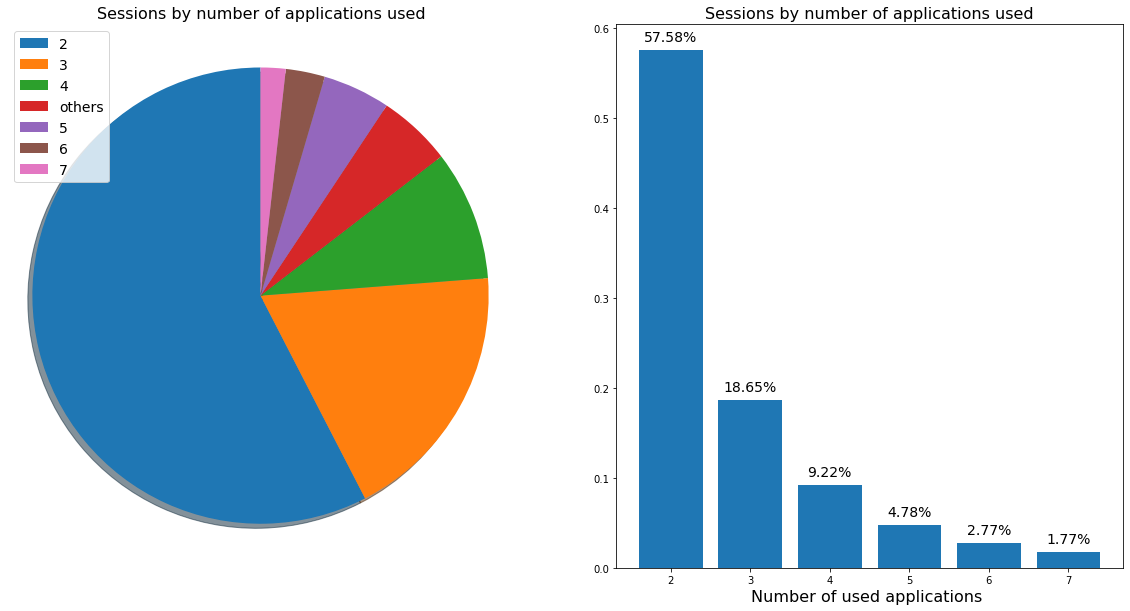

In [185]:
ses_dur_dis = filtered_df_2[["session_hk_c","num_apps"]].drop_duplicates()["num_apps"]\
                    .value_counts(normalize=True)
labels,data = ses_dur_dis.index, ses_dur_dis.values
plot_distribution(labels,data,"Sessions by number of applications used",top_n_pie=6, top_n_hist=6,xlabel="Number of used applications ",pie_legend=True)

# SESSION DURATION DISTRIBUTION

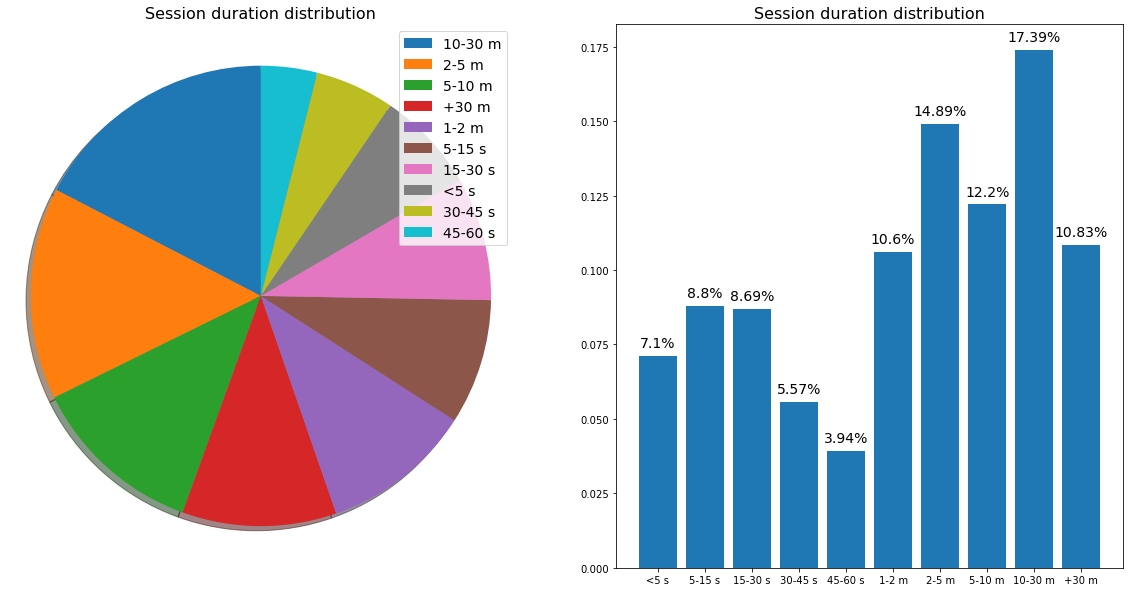

In [186]:
ses_dur_dis = filtered_df_2[["session_hk_c","session_duration_range"]].drop_duplicates()["session_duration_range"]\
                    .value_counts(normalize=True)
labels,data  = sort_serie_with_duration_ranges(ses_dur_dis)
plot_distribution(labels,data,"Session duration distribution",top_n_pie=10, top_n_hist=10,xlabel="",pie_legend=True,bar_annot_extra=0.003)

# SESSION DISTRIBUTION BY TYPE OF USER

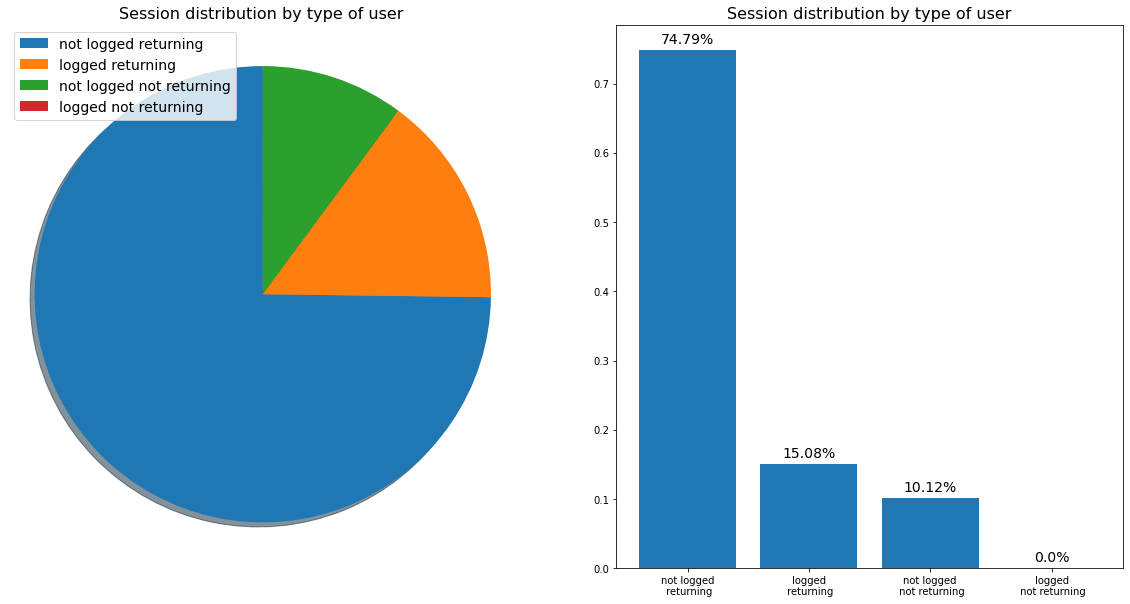

In [187]:
user_type_dis = filtered_df_2[["session_hk_c","visitor_id_c","user_description"]].drop_duplicates()\
                ["user_description"].value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"Session distribution by type of user",top_n_pie=8, top_n_hist=5,xlabel="",pie_legend=True)

# NUMBER OF SESSIONS BY USER

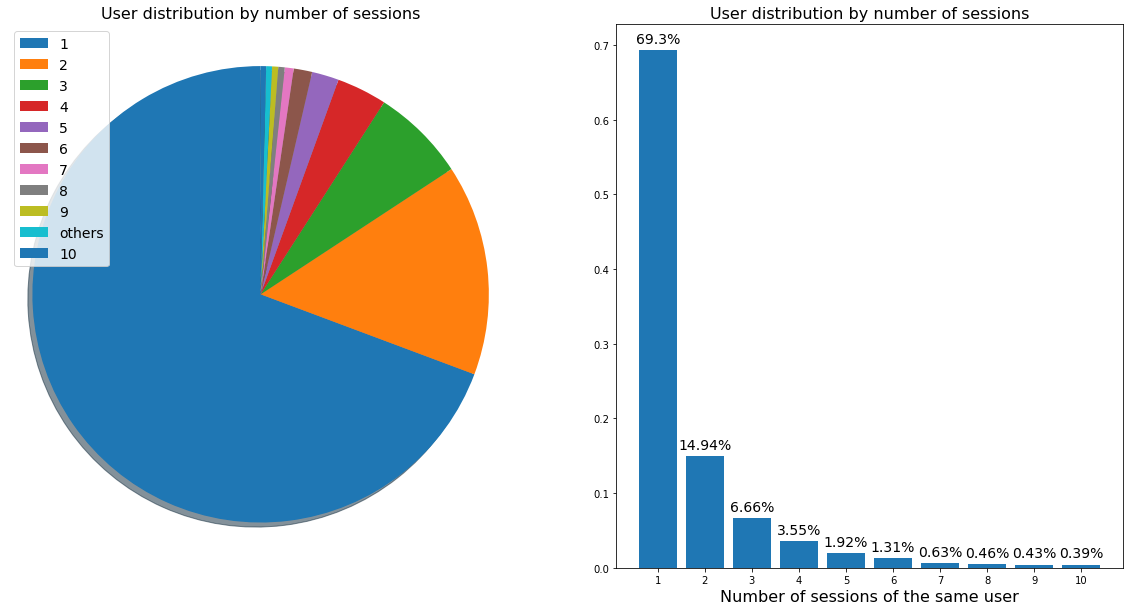

In [188]:
user_type_dis = filtered_df_2[["session_hk_c","visitor_id_c","user_description"]].drop_duplicates()\
                .groupby("visitor_id_c")["visitor_id_c"].transform("count").value_counts(normalize=True)
labels,data = user_type_dis.index, user_type_dis.values
plot_distribution(labels,data,"User distribution by number of sessions",top_n_pie=10, top_n_hist=10,xlabel="Number of sessions of the same user",pie_legend=True)